# Raster visualization: Flood monitoring using Earth Observation

This tutorial/exercise explores different ways of visualization earth observation imagery. We explore time series collected around a flooding event using Sentinel 2 as a use case.

# Data

We use data products from the Sentinel 2 Mission from the Copernicus programme. Sentinel 2 consists of two satellite platforms collecting imagery with the same multi spectral Imagery sensor. There are two satellites:

- Sentinel 2A was launched on June 23
- Sentinel 2B was launched on March 7 2017.

Sentinel 2 satellites have revisit time of 10 days under the same angles with higher revisit times in higher latitudes and more revisit times if we consider both Sentinel 2A and 2B together. Sentinel 2 data is distributed as granules (tiles) that are 100x100 km2 ortho-images in UTM/WGS84 projection.

Because the satellite path crosses the meridians the tiles collected are triangular or trapezoidal in shape and do not follow the UTM square gridding used to distribute the data.

# Abrupt Event

To explore the use of Sentinel 2 data, we use Vermont flooding that occured between July 9 and 11, 2023. This flood event had a major impact on the state with 14 counties declared as state disaster. River levels increased across the state and the Winooski River near Montpellier, the state capital, jumped by 14 feet within a 20 hour time period.

## Interesting links:

- GDAL tutorial:

https://www.kaggle.com/code/samanemami/a-complete-tutorial-on-raster-data-analysis?scriptVersionId=110771922

- STAC and COGS

Each pystac.Item <https://pystac.readthedocs.io/en/stable/api/pystac.html#pystac.Item>__ in this ItemCollection includes all the metadata for that scene. STAC Items are GeoJSON features, and so can be loaded by libraries like geopandas.

- course:

http://spatial-ecology.net/docs/build/html/WEBSEMINAR/webseminar.html

https://planetarycomputer.microsoft.com/docs/quickstarts/reading-stac/

https://github.com/stac-utils/pystac-client/blob/df034494c2d566f0b2fa6fb8f0455f75d10e0b62/docs/tutorials/pystac-client-introduction.ipynb

https://kodu.ut.ee/~kmoch/geopython2019/L4/raster.html


- Analyzing sentinel 2 with GEE in python:

https://worldbank.github.io/OpenNightLights/tutorials/mod6_3_intro_to_sentinel2.html


- GDAL Time series

https://ucl-eo.github.io/geog0111/041_GDAL_timeseries_answers/


https://documentation.dataspace.copernicus.eu/APIs/SentinelHub/Catalog.html

https://gis.stackexchange.com/questions/178535/how-can-i-use-gdal-merge-with-multiple-files-in-one-folder-in-python-2-7


- Copernicus Dataspace Ecosystem

https://documentation.dataspace.copernicus.eu/APIs/STAC.html


- Visualize and explore multibands time series from Sentinel with xarray


https://medium.com/@bonnefond.virginie/handling-multi-temporal-satellite-images-with-xarray-30d142d3391

- NASA Earth data via STAC

https://nasa-openscapes.github.io/2021-Cloud-Hackathon/tutorials/02_Data_Discovery_CMR-STAC_API.html

https://hls.gsfc.nasa.gov/products-description/tiling-system/

- Flooding datasets:

https://github.com/cloudtostreet/Sen1Floods11

- Flooding event in Vermont:

https://floodlist.com/america/usa/floods-vermont-july-2023

https://www.vermontpublic.org/2023-07-13/maps-which-areas-in-vermont-were-hit-hardest-in-this-weeks-flooding

https://maps.disasters.nasa.gov/arcgis/apps/MinimalGallery/index.html?appid=79638a63d4824520bb3360415b37a9bd

https://maps.disasters.nasa.gov/download/gis_products/event_specific/2023/vermont_flooding_202307/sentinel2/20230706/cir/

https://cimss.ssec.wisc.edu/satellite-blog/archives/53377


- visualizes the boundaries of the S-2 granules imaged on a single day.

https://gis.stackexchange.com/questions/395456/why-is-the-sentinel-2-image-plot-triangular-in-google-earth-engine


# Set up environment and load libraries

- load libraries
- install packages and tools
- authenticate to google drive and gcp account

First let's list a few parameters to understand the computing environment that we are using. In particular:
- os system
- python version
- hostname

In [1]:
!uname -a
!lsb_release -a
!python --version
!hostname
!whoami

Linux 2a8d3c558ff0 6.1.85+ #1 SMP PREEMPT_DYNAMIC Thu Jun 27 21:05:47 UTC 2024 x86_64 x86_64 x86_64 GNU/Linux
No LSB modules are available.
Distributor ID:	Ubuntu
Description:	Ubuntu 22.04.3 LTS
Release:	22.04
Codename:	jammy
Python 3.10.12
2a8d3c558ff0
root


Let's then install GDAL binaries and spatial libraries necessary for gdal, rasterio and xarray.

In [2]:
#install gdal to run from the terminal
!sudo add-apt-repository ppa:ubuntugis/ppa -y
!sudo apt-get update
!sudo apt-get install gdal-bin
!gdalinfo --version

PPA publishes dbgsym, you may need to include 'main/debug' component
Repository: 'deb https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu/ jammy main'
Description:
Official stable UbuntuGIS packages.


More info: https://launchpad.net/~ubuntugis/+archive/ubuntu/ppa
Adding repository.
Found existing deb entry in /etc/apt/sources.list.d/ubuntugis-ubuntu-ppa-jammy.list
Adding deb entry to /etc/apt/sources.list.d/ubuntugis-ubuntu-ppa-jammy.list
Found existing deb-src entry in /etc/apt/sources.list.d/ubuntugis-ubuntu-ppa-jammy.list
Adding disabled deb-src entry to /etc/apt/sources.list.d/ubuntugis-ubuntu-ppa-jammy.list
Adding key to /etc/apt/trusted.gpg.d/ubuntugis-ubuntu-ppa.gpg with fingerprint 2EC86B48E6A9F326623CD22FFF0E7BBEC491C6A1
Get:1 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Hit:2 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:3 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,626 B]
Get:4 https://developer.download.nvidia.co

Install other geospatial related libraries

In [4]:
#set up libararies for GIS/Geospatial
try: # try the following b+lock of code
  import geopandas as gpd
except: # if the try block throws an error, run the following
  !pip install geopandas # install geopandas
  import geopandas as gpd

try:
  import contextily as ctx # import
  import rasterio
  import fiona
except:
  !apt install libproj-dev proj-data proj-bin
  !apt install libgeos-dev
  !pip install cython
  !pip install cartopy
  !pip install rasterio
  !pip install fiona
  !pip install contextily
  import contextily as ctx # import
  import rasterio
import fiona # library for reading/writing GIS files, comes w/ geopandas
from shapely.geometry import Point, LineString, Polygon

!pip install pyproj
# Mapping,vector related imports
import geopandas as gpd
#import descartes #nessary for plotting in geopandas
from cartopy import crs as ccrs
from pyproj import Proj
#from osgeo import osr
from shapely import geometry
from shapely.geometry import Point
from shapely.geometry import box
from shapely.geometry import shape
from shapely.geometry import Polygon

from collections import OrderedDict
#rasterio imports, gdal and imagery utility
import rasterio
from rasterio.windows import Window
from osgeo import gdal
from rasterio import plot
from PIL import Image

#xarray and rio
!pip install rioxarray
!pip install mapclassify
!pip install earthpy

import mapclassify
import folium
import pyproj as proj
import xarray as xr
import rioxarray as rxr
import earthpy as et
import earthpy.plot as ep
from folium.utilities import none_max
import folium
from pyproj import Transformer

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
libproj-dev is already the newest version (9.1.1-1~jammy0).
proj-bin is already the newest version (9.1.1-1~jammy0).
proj-data is already the newest version (9.1.1-1~jammy0).
0 upgraded, 0 newly installed, 0 to remove and 52 not upgraded.
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
libgeos-dev is already the newest version (3.11.1-1~jammy0).
0 upgraded, 0 newly installed, 0 to remove and 52 not upgraded.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.6/56.6 kB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.3/17.3 MB 73.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.1/59.1 kB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 13.3 MB/s eta 0:00:00


General purpose libraries and packages

In [5]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
from matplotlib.colors import ListedColormap, BoundaryNorm
from matplotlib import colors
import matplotlib.patches as mpatches
import seaborn as sns

import numpy as np
import subprocess
import pandas as pd
import os, glob
import zipfile

from pathlib import Path

sns.set_style('darkgrid')
#pd.set_option('display.max_colwidth', None)
!apt install unzip
import urllib
import re
import math
from datetime import datetime
from copy import deepcopy
from numpy.core.multiarray import datetime_as_string
import os
import numpy.ma as ma

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
unzip is already the newest version (6.0-26ubuntu3.2).
0 upgraded, 0 newly installed, 0 to remove and 52 not upgraded.


In [6]:
#Used in defining functions
from typing import List, Tuple, Dict, Any
from pandas.core.arrays import boolean

Install STAC related libraries

- https://pystac-client.readthedocs.io/_/downloads/en/stable/pdf/
- https://github.com/stac-utils/pystac-client/blob/df034494c2d566f0b2fa6fb8f0455f75d10e0b62/docs/tutorials/aoi-coverage.ipynb


In [7]:
!pip install pystac
#!pystac_client
!pip install pystac-client
!pip install planetary-computer
import planetary_computer

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.9/183.9 kB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.9/41.9 kB 1.7 MB/s eta 0:00:00


In [8]:
#GCP account authentification
from google.colab import auth
auth.authenticate_user()
print('Authenticated')

Authenticated


In [9]:
from google.colab import drive

drive.mount('/content/gdrive')

Mounted at /content/gdrive


# Functions
In the next part of the script, we declare all the functions used in the sripts.  It is good practice to place functions at the beginning of a script or in an external source file. Here are the 13 functions used:

In [10]:
def create_dir_and_check_existence(path: str) -> str:
  '''
  Create a new directory

  :param path: path to the directory
  :return: path to the directory
  '''

  try:
    os.makedirs(path)
  except:
    print ("directory already exists")
  return path



In [11]:
def dms_to_dd(val: np.float32) -> np.float32:
  '''
  Convert dms: degree minute second to decimal degree
  Note that the format expect direction with W or S.

  :param val: degree minute second
  :return: decimal degree
  '''

  deg,minute,second,direction = re.split('[°\'\"]', val)
  dd_val = float(deg)+float(minute)/60+float(second)/(60*60)
  if direction == 'W' or direction == 'S':
    dd_val = (-1.)*dd_val
  return dd_val

In [12]:

def bbox_to_poly(bbox: list) -> Polygon:

  '''
  Convert bounding box list into a polygon. With input list xmin,ymin,xmax,ymax.

  :param bbox list: list of coordinates represending a bouding.
  :return: Shapely polygon

  '''

  long0 = bbox[0]
  lat0 = bbox[1]
  long1=bbox[2]
  lat1=bbox[3]

  poly = Polygon([[long0, lat0],
                        [long1,lat0],
                        [long1,lat1],
                        [long0, lat1]])

  return poly

In [13]:
def polygon_from_centroid(x_centroid,y_centroid,size,EPSG_val=4326)-> gpd.GeoDataFrame:

  '''

  Generate a square polygon from center point with a given size and EPSG code
  Return a GeoDataFrame

  :param x_centroid float32: x center of square polygon being created
  :param y_centroid float32: y center of square polygon being created
  :param size float32: length of square polygon
  :param EPSG_val int: EPSG code defining the coordinate system
  :return geopandas geodataframe

  '''

  xmin = x_centroid - size/2
  xmax = x_centroid + size/2
  ymin = y_centroid - size/2
  ymax = y_centroid + size/2

  bbox_list = [xmin,ymin,xmax,ymax]
  bbox_poly = bbox_to_poly(bbox_list)

  bbox_poly_gdf = gpd.GeoDataFrame(pd.DataFrame(['p1'], columns = ['geom']),
         crs = {'init':f'epsg:{EPSG_val}'},
         geometry = [bbox_poly])
  bbox_poly_gdf.to_file('bbox_poly.shp')

  return bbox_poly_gdf

In [14]:
#https://aws.amazon.com/blogs/apn/transforming-geospatial-data-to-cloud-native-frameworks-with-element-84-on-aws/
#https://github.com/stac-utils/pystac-client/blob/1eaf0d97632c411279e8312b337faf842d657474/docs/tutorials/stac-metadata-viz.ipynb
def items_to_geodataframe(items: any) -> gpd.GeoDataFrame:
    '''
    Convert a list of STAC Items into a GeoDataFrame.
    Modified from https://github.com/stac-utils/pystac-client/blob/1eaf0d97632c411279e8312b337faf842d657474/docs/tutorials/stac-metadata-viz.ipynb

    :param items: list of STAC Items
    :return: GeoDataFrame
    '''

    #Using from copy import deepcopy
    _items = []
    for i in items:
        _i = deepcopy(i)
        _i['geometry'] = shape(_i['geometry'])
        _items.append(_i)
    gdf = gpd.GeoDataFrame(pd.json_normalize(_items))
    for field in ['properties.datetime', 'properties.created', 'properties.updated']:
        if field in gdf:
            gdf[field] = pd.to_datetime(gdf[field])
    gdf.set_index('properties.datetime', inplace=True)
    return gdf

In [15]:
from pystac_client import item_search
#https://github.com/stac-utils/pystac-client/blob/1eaf0d97632c411279e8312b337faf842d657474/docs/tutorials/stac-metadata-viz.ipynb
def get_selected_products_and_bands(cat_search: item_search.ItemSearch,
                                    bands_selected: list[str],
                                    platform: str='Sentinel-2A') -> pd.DataFrame:

  '''
  Get the selected products and bands from STAC

  :param items: pystac_client item search object
  :param bands_selected: list of bands to filter
  :return: pandas data frame containing the selected products and bands
  '''

  items_dict = [i.to_dict() for i in cat_search.get_items()]
  print(f"{len(items_dict)} scenes fetched")
  items = items_to_geodataframe(items_dict)
  bands_selected = [f'assets.{b}.href'for b in bands_selected]
  bands_selected
  col_selected = bands_selected + ['collection','id','properties.s2:mgrs_tile','properties.proj:epsg']
  if platform is not None:
    selected_products = items.loc[items['properties.platform']==platform,col_selected] #filter for relevant platform
  else:
    selected_products = items.loc[:,col_selected] #filter for relevant platform

  selected_products = selected_products.reset_index()
  print(selected_products['properties.datetime'].dtypes)
  selected_products['date'] = selected_products['properties.datetime'].dt.date
  selected_products['date'] = selected_products['date'].astype(str)
  list_dates = list(selected_products['date'].unique())
  list_tiles = selected_products['properties.s2:mgrs_tile'].unique()

  return selected_products

In [16]:
#Change the name of the file to include date and better formatting
#Also adjust the resolution
def download_and_reproject_stac_file(date_val:str,
                                     selected_products:pd.DataFrame,
                                     download: bool,
                                     aoi_poly:gpd.GeoDataFrame,
                                     output_epsg: int=None,
                                     output_res: np.float32=None,
                                     out_dir:str='.') -> str:
  '''
  Download and reproject STAC files

  :param date_val: str: date to download and process
  :param selected_products: pd.DataFrame
  :param download: boolean, if true download the raw file without processing
  :param aoi_poly: gpd.GeoDataFrame containing the reference poygon of Area of Interest
  :param output_epsg: int code for EPSG projection coordinate system
  :param output_res: np.float32 resolution of output raster
  :param out_dir: str path to output directory
  :return: output raster file name containing the processed raster
   '''

  bands_cols = list(selected_products.filter(regex='assets').columns)

  for band in bands_cols:
    if download is True:
        raster_file_list = selected_products.loc[selected_products['date']==date_val,band].tolist()
        out_raster_file =[]
        for raster_file in raster_file_list:
           download_path = os.path.join(selected_products.collection)
           in_filename = raster_file
           out_filename = os.path.basename(in_filename.split('?'))[0] #split the name on ?
           os.makedirs(download_path, exist_ok=True)
           out_filename = os.path.join(out_dir,out_filename)
           urllib.request.urlretrieve(in_filename,
                                   out_filename)

           out_raster_file.append(out_filename)

    #crop and project if download is false
    if download is False:

      # Set the AOI cropping
      proj_crs = selected_products.loc[selected_products['date']==date_val,'properties.proj:epsg'].tolist()
      print(proj_crs) #this is the EPSG code
      aoi_poly_proj = aoi_poly.to_crs(f'EPSG:{proj_crs[0]}') #should first extract current EPSG!!
      aoi_poly_proj.to_file('aoi_poly_proj.shp')
      aoi_poly_proj.crs

      #Set the resolution for the ouput
      if output_res is None:
        #if unit is degree we need to call a function
        #if not we use the same res as input
        output_res=0.00009
        #this still needs to be improve
        #use input raster to match the res in the output projection given
      if output_epsg is None:
        crs_val=(aoi_poly.crs.srs)
        epsg_code = crs_val.split(':')[1][:4]
        output_epsg = f'EPSG:{epsg_code}'
      data_val_formatted = date_val.replace("-","")

      download_path = os.path.join(selected_products.collection.unique()[0],
                                    data_val_formatted)
      os.makedirs(download_path, exist_ok=True) # add date

      out_filename=os.path.join(out_dir,
                                download_path, #add date in output path?
                                f'crop_proj_{selected_products2.collection.unique()[0]}_{band}_{data_val_formatted}.tif')
      raster_file_list = selected_products.loc[selected_products['date']==date_val,band].tolist()

      #from pathlib import Path
      out_filename_vrt = Path(out_filename).stem

      raster_file_list_m = [f'/vsicurl/{u}' for u in raster_file_list]

      ds = gdal.BuildVRT( f'{out_filename_vrt}.vrt',
                         raster_file_list_m,
                          VRTNodata=0,
                          srcNodata=0)

      #dstSRS should not be hard coded
      result = gdal.Warp(out_filename,
                          ds,
                          format='GTiff',
                          dstNodata=0,
                          dstSRS= output_epsg, #this should not be hard coded
                          cutlineDSName='aoi_poly_proj.shp',
                          cropToCutline=True,
                          xRes=output_res, #this should not be hard coded
                          yRes=output_res)
      result=None
      out_raster_file = out_filename

  return out_raster_file

In [17]:
#https://gis.stackexchange.com/questions/290796/how-to-edit-the-metadata-for-individual-bands-of-a-multiband-raster-preferably
def update_description_gdal(filepath: str,
                            list_desc: List) -> str:

  '''
  Update the description of a raster file using GDAL

  :param filepath: path/virtual path/uri to raster
  :param list_desc: list of string values for each band description, eg dates
  :return: str stating that the description was updated
  '''

  ds_src = gdal.Open(filepath, gdal.GA_Update)
  i=0
  for desc_val in list_desc:
    i=i+1
    rb = ds_src.GetRasterBand(i)
    rb.SetDescription(desc_val)
  del ds_src
  return "updated descriptions"

In [18]:
## Now set no data and description + recalculate stats after that

def update_nodata_val_raster(in_filename: str,
                             band_val: int=1,
                             nodata_val: int=0) -> str:
  '''
  Update the nodata value of a raster file using GDAL

  :param in_filename: path to raster filep
  :param band_val: band number
  :param nodata_val: nodata value to set
  :return: str stating that the description was updated

  '''

  ds = gdal.Open(in_filename,1) # The 1 means that you are opening the file to edit it)
  rb = ds.GetRasterBand(band_val) #assuming your raster has 1 band.
  rb.SetNoDataValue(nodata_val)
  rb= None
  ds = None
  return 'Nodata value updated'

In [19]:
def generate_qa_table_sentinel2() -> pd.DataFrame:

  '''

  Generate a reference table wtih value and corresponding label description for Sentinel 2
  Quality Pixel from teh Scene Land Classificaiton

  :return DataFrame with SCL description
  '''

  #https://docs.digitalearthafrica.org/en/latest/data_specs/Sentinel-2_Level-2A_specs.html
  #https://custom-scripts.sentinel-hub.com/custom-scripts/sentinel-2/scene-classification/

  from io import StringIO, BytesIO

  text_string = StringIO("""value,class,HTLM color code
  0,No Data (Missing data),#000000
  1,Saturated or defective pixel,#ff0000
  2,Dark features/Shadows',#2f2f2f
  3,Cloud shadows,#643200
  4,Vegetation,#00a000
  5,Not-vegetated,#ffe65a
  6,Water,#0000ff
  7,Unclassified,#808080
  8,Cloud medium probability,#c0c0c0
  9,Cloud high probability,#ffffff
  10,Thin cirrus,#64c8ff
  11,Snow or ice,#ff96ff
  """)
  SCL_legend_df = pd.read_csv(text_string, sep=",")

  return  SCL_legend_df

In [20]:
def generate_apply_qa_raster_sentinel2(mask_values: List[int],
                                       input_filename_qa: str,
                                       input_filename_var: str,
                                       output_filename: str,
                                       in_dir: str,
                                       max_val: int = 10000,
                                       out_dir: str ='.'
                                       ) -> tuple[str,str]:

  '''
  Apply masking of qa pixel values on Sentinel 2 product.
  Users profiles a list of values to mask.

  :param mask_values: list of values to mask
  :param input_filename_qa: input filename containing SCL QA pixel values
  :param input_filename_var: Sentinel 2 band product filename e.g. B03 reflectance band
  :param in_dir: input directory containing files
  :param out_dir: output directory for files
  :return tuple cmd_str, output_filename

  '''
  df_legend_SCL =generate_qa_table_sentinel2()
  df_legend_SCL['valid']=df_legend_SCL.apply(lambda x: 0 if x.value in mask_values else 1,axis=1)#df2 = df.apply(lambda x: np.square(x) if x.name in ['A','B'] else x)
  df_legend_SCL['valid']
  list_pix_val = df_legend_SCL['value'].tolist()
  list_valid = df_legend_SCL['valid'].tolist()

  if max_val is None:
    max_val = 65536 #this will take all the value below the max for uint16

  os.chdir(in_dir)


  list_args =['gdal_calc.py',
              f'-A {input_filename_qa}',
              f'-B {input_filename_var}',
              '--A_band=1',
              '--B_band=1',
              f'--calc="(A=={list_pix_val[0]})*{list_valid[0]}*(B<={max_val})*B +',
              f'(A=={list_pix_val[1]})*{list_valid[1]}*(B<={max_val})*B +',
              f'(A=={list_pix_val[2]})*{list_valid[2]}*(B<={max_val})*B +',
              f'(A=={list_pix_val[3]})*{list_valid[3]}*(B<={max_val})*B +',
              f'(A=={list_pix_val[4]})*{list_valid[4]}*(B<={max_val})*B +',
              f'(A=={list_pix_val[5]})*{list_valid[5]}*(B<={max_val})*B +',
              f'(A=={list_pix_val[6]})*{list_valid[6]}*(B<={max_val})*B +',
              f'(A=={list_pix_val[7]})*{list_valid[7]}*(B<={max_val})*B +',
              f'(A=={list_pix_val[8]})*{list_valid[8]}*(B<={max_val})*B +',
              f'(A=={list_pix_val[9]})*{list_valid[9]}*(B<={max_val})*B +',
              f'(A=={list_pix_val[10]})*{list_valid[10]}*(B<={max_val})*B +',
              f'(A=={list_pix_val[11]})*{list_valid[11]}*(B<={max_val})*B"',
              '--hideNoData',
              '--overwrite',
              '--outfile',
              f'{output_filename}']

  cmd_str = ' '.join([str(elem) for elem in list_args])
  #print(cmd_str)
  import subprocess
  env = os.environ.copy() #this is necessary in google colab
  output_sub = subprocess.check_output(cmd_str, shell=True, env=env,text=True)
  #print(output_sub)
  #os.chdir(out_dir)

  return cmd_str, output_filename


In [21]:
def freq_array(r: str|rasterio.io.DatasetReader,
               band_number: int=1) -> pd.DataFrame:

  '''
  Compute unique values and frequency for raster input.

  :param r: input raster filename or rasterio dataset
  :param band_number: band number for rasterio dataset
  '''
  if isinstance(r,rasterio.io.DatasetReader):
    r = r.read(band_number)
  unique, counts = np.unique(r, return_counts=True)
  unique_val = np.asarray((unique, counts)).T
  unique_val_df = pd.DataFrame(unique_val,columns=['value','count'])
  return unique_val_df

In [22]:
def extract_proj_unit(epsg_val: int =4326) -> pd.DataFrame:

  '''
  Extract unit used in Coordinate Reference System identified by the EPSG code
  provided.

  :param  epsg_val: EPSG code value for coordinate reference system
  :return data frame containing unit, direction, name of CRS
  '''

  pyproj_crs = proj.CRS.from_epsg(epsg_val)
  list_unit_crs = [ai.unit_name for ai in pyproj_crs.axis_info]
  list_name_crs = [ai.name for ai in pyproj_crs.axis_info]
  list_direction_crs = [ai.direction for ai in pyproj_crs.axis_info]
  list_abbrev_crs = [ai.abbrev for ai in pyproj_crs.axis_info]
  proj_unit_df = pd.DataFrame.from_dict({"unit":list_unit_crs,
                        "name": list_name_crs,
                        "abbrev": list_abbrev_crs,
                        "direction": list_direction_crs})
  #https://gis.stackexchange.com/questions/299759/where-to-lookup-the-units-associated-with-epsg-code

  return proj_unit_df

In [23]:
def match_spatial_resolution(aoi_poly: gpd.GeoDataFrame,
                             in_file_raster: str,
                             epsg_raster: int =None,
                             epsg_poly: int=None) -> float:
  '''
  Match spatial resolution of the input raster given a geopandas data frame for the AOI polygon.

  :param aoi_poly geodataframe corresponding to the area of interest.
  :param in_file_raster: name of input raster file
  :param epsg_raster: EPSG code for raster, if None read for input raster
  :param epsg_poly: EPSG code for AOI polygon, if None read from input AOI geodataframe

  '''

  print(raster_file_list[0])
  ds_r = rasterio.open(in_file_raster)
  res_x= ds_r.transform.a
  res_y= ds_r.transform.e
  if epsg_raster is None:
    epsg_val_r = ds_r.crs.to_epsg()

  if epsg_poly is None:
    crs_val=(aoi_poly.crs.srs)
    epsg_val_poly = crs_val.split(':')[1][:4]

  r_unit_df = extract_proj_unit(epsg_val_r)
  poly_unit_df = extract_proj_unit(epsg_val_poly)

  unit_r = np.unique(r_unit_df.unit.values)[0]
  unit_poly = np.unique(poly_unit_df.unit.values)[0]

  if (unit_poly=='degree') and (unit_r=='metre'):
    ratio_km = 1000/res_x
    output_res = round((1/111)/ratio_km, 5)
  if (unit_poly=='degree') and (unit_r=='degree'):
    output_res = res_x
  if (unit_poly=='metre') and (unit_r=='metre'):
    output_res=res_x
  return output_res

In [24]:
def plot_raster_categories(in_filename: str,
                           color_list: List =None,
                           class_names: List[str]=None,
                           title_str: str=None)->str:
  '''
  Plot categorical raster given input file name

  :param in_filename: input file name
  :param color_list: list of colors for categories plotted
  :param class_names: list of categories names
  :title_str: title for the plot
  :return title_str: 'plotted' message
  '''

  if title_str is None:
    title_str =""
  sns.set(font_scale=1.5, style="whitegrid")

  ## Loading TIF file
  r_rxr = rxr.open_rasterio(in_filename,
                            masked=True).squeeze()
  r_rxr = r_rxr.astype('uint16')

  ### Getting unique classes from array and setting color and legend list

  classes_rxr = list(np.unique(r_rxr).astype('int'))
  n_classes = len(classes_rxr)
  # Plot newly classified and masked raster
  if color_list is None:
    color_list = sns.color_palette("pastel",n_classes)
    color_list =list(color_list.as_hex())
  if class_names is None:
    class_names = ['class_' + str(i) for i in classes_rxr]


  cmap_val = ListedColormap(color_list) #from matplotlib.colors
  f, ax = plt.subplots(figsize=(12,6))
  im = ax.imshow(r_rxr,
                cmap = cmap_val)
  ax.set(title=title_str)
  ep.draw_legend(im,
                titles = class_names,
                classes = classes_rxr)
  ax.set_axis_off()
  plt.show()

  return 'plotted'


In [25]:
def update_raster_band_stats(in_filename: str,
                             band_val: int =1) -> pd.DataFrame:

  '''

  Update raster file stats using GDAL

  :param in_filename: input file name
  :param band_val: band value to be updated
  :return df_stats: DataFrame containing statistics including min,max,mean and std.

  '''
  ds = gdal.Open(in_filename,1) # The 1 means that you are opening the file to edit it)
  rb = ds.GetRasterBand(band_val) #assuming your raster has 1 band.
  stats =   rb.GetStatistics(0,1)
  rb= None
  ds = None
  df_stats = pd.DataFrame({'min':[stats[0]],
                          'max':[stats[1]],
                          'mean':[stats[2]],
                          'std':[stats[3]]})
  return df_stats

In [26]:
#Create  function to create a time series
#Need to add the description

def generate_time_series_raster(file_pattern: str,
                                 in_dir: str,
                                 dstNodata_val: int=None,
                                 srcNodata_val: int=None,
                                 out_suffix: str=None,
                                 out_dir: str=".") -> tuple[str,str,pd.DataFrame]:

  '''

  Create a time series multiband raster file, vrt and data frame with list of corresponding files. This functions
  will create a list of input band fiel corresponding to each time step.

  :param file_pattern: pattern to match in file name
  :param in_dir: input directory
  :param dstNodata_val: integer value use for No Data output file
  :param srcNodata_val: integer value use for No Data input file
  :param out_suffix: output suffix
  :param out_dir: output directory
  :return out_file_raster: output raster file
  :return out_file_vrt: output vrt file
  :return df_files_raster: data frame with list of corresponding files.

  '''

  path_raster = os.path.join(in_dir,file_pattern) #raw raster
  files_raster_sat = glob.glob(path_raster,recursive=True)

  #we need to order the dates
  df_files_raster = pd.DataFrame({'files':files_raster_sat})
  df_files_raster['date'] = (df_files_raster['files'].str.split("_").str[-1]).str.replace(".tif","")
  df_files_raster['date'] = (pd.to_datetime(df_files_raster['date']))
  df_files_raster = df_files_raster.sort_values(by='date')
  df_files_raster = df_files_raster.reset_index(drop=True)

  if out_suffix is None:
    out_file_vrt = os.path.join(out_dir,f"time_series.vrt")
  else:
    out_file_vrt = os.path.join(out_dir,f"{out_suffix}_time_series.vrt")

  files_raster = df_files_raster['files'].tolist()

  if (dstNodata_val is None) and (srcNodata_val is None):
    ds_ts = gdal.BuildVRT(out_file_vrt,
                          files_raster,
                          separate=True,
                          callback=gdal.TermProgress_nocb)
  else:
    ds_ts = gdal.BuildVRT(out_file_vrt,
                          files_raster,
                          separate=True,
                          VRTNodata=dstNodata_val,
                          srcNodata=srcNodata_val,
                          callback=gdal.TermProgress_nocb)

  ds_ts.GetDescription()

  #InputImage = gdal.Open(VRT, 0)  # open the VRT in read-only mode
  if out_suffix is None:
    out_file_raster = os.path.join(out_dir,f"time_series.tif")
  else:
    out_file_raster = os.path.join(out_dir,f"{out_suffix}_time_series.tif")

  gdal.Translate(out_file_raster,
                ds_ts,
                format='GTiff',
                creationOptions=['COMPRESS:DEFLATE', 'TILED:YES'],
                callback=gdal.TermProgress_nocb)
  del ds_ts   # close the VRT

  return out_file_raster, out_file_vrt,df_files_raster


In [27]:
#this is coming from:
#https://github.com/bparment1/rastermodel/blob/master/rastermodel/rastermodeling.py

def raster_compute_proportion(rast_in: str | list,
                              nodata_val: int=-9999,
                              out_nodata_val: int=0,
                              dtype_val: str=None,
                              out_filename: str=None,
                              out_dir: str =None,
                              count_val: str =None,
                              val=4) -> str:
    '''

    Compute proportion of pixels in a raster

    :param rast_in: input raster
    :param nodata_val: nodata value
    :param out_nodata_val: output nodata value
    :param dtype_val : data type for output
    :param out_filename: output file name
    :param out_dir: output directory
    :param count_val: count value
    :param val: value to compute proportion
    :return: out_filename: output file name

    '''

    if out_dir is not None:
      out_filename = os.path.join(out_dir,out_filename)

    ## Check for type:
    if(type(rast_in)==list):
        src_RP1 = rasterio.open(rast_in[0])
        src_RP =  list(map(lambda x: rasterio.open(x) , rast_in))
        n_layers = len(src_RP)
    else:
        src_RP1 = rasterio.open(rast_in)
        n_layers = 1

    #Add multiband support:
    if(src_RP1.count >1):
        n_layers= src_RP1.count

    ## Option  to set the dtype from the predicted val??
    ## Check if file exists first, still a problem here

    exists = os.path.isfile(out_filename)

    if exists:
        print("File already exists, removing file")
        os.remove(out_filename)

        out_profile = src_RP1.profile.copy()

        if dtype_val!= None:
            nodata_val = rasterio.dtypes.dtype_ranges[dtype_val][0] #take min val of range
            out_profile['dtype']=dtype_val
            out_profile['nodata']=nodata_val
        if count_val is not None:
          out_profile['count']= count_val
        dst = rasterio.open(out_filename,
                        'w',
                        **out_profile)
    else:
        print("creating file")
        out_profile = src_RP1.profile.copy()
        if dtype_val!= None:
            nodata_val = rasterio.dtypes.dtype_ranges[dtype_val][0] #take min val of range
            out_profile['dtype']=dtype_val
            out_profile['nodata']=nodata_val
        if count_val is not None:
          out_profile['count']= count_val
        dst = rasterio.open(out_filename,
                        'w',
                        **out_profile)

    i=0
    #src_RP1.block_windows(1) use 1 to have alll the bands included
    for block_index, window in src_RP1.block_windows(1):
        i = i  + 1 #tracking if this is the first window
        RP1_block = src_RP1.read(window=window, masked=True)
        #print(RP1_block.shape)

        if(type(rast_in)==list):
            RP_block =  list(map(lambda x,window: x.read(window=window, masked=True) , src_RP,repeat(window)))
            RP_block =  list(map(lambda x: x.ravel() , RP_block))
            RP_block =  np.stack(RP_block, axis=1)
        else:
            RP_block = RP1_block
            #RP_block = RP_block.ravel() #only sample of the form (20,), missing feature
            #RP_block = RP_block.reshape(-1,1)

        shape_block = RP1_block.shape #need with and heigt

        if dtype_val!= None:
            RP_block = RP_block.astype(dtype_val)

        result_block = proportion_pix(
            pix=RP_block,
            val=val)

        #if this i the first window blocked processed check that the data type match
        #the output and array computed
        #could also check the count or with and heigth
        if i ==1:
          #check the out_profile:
          if (result_block.dtype != out_profile['dtype']) or (result_block.count != out_profile['count']) :
            out_profile['dtype'] = result_block.dtype
            out_profile['count'] = result_block.shape[0]
            dst.close()
            os.remove(out_filename)
            dst = rasterio.open(out_filename,
                        'w',
                        **out_profile)

        dst.write(result_block, window=window)

    src_RP1.close()
    if(type(rast_in)==list):
      out_close = list(map(lambda x: x.close(), src_RP))
    dst.close()

    return out_filename

In [28]:
def proportion_pix(pix: np.array,
                   val: int) -> np.array:

  '''
  Compute the proportion of pixel with a specific value in a numpy array

  :param pix: numpy array containing values to be matched
  :param val: value to match in the array to calcuate the proportion
  :return

  '''
  pix_bool = np.where(pix==val,1,0)
  prop = np.nanmean(pix_bool,axis=(0),keepdims=True)
  return prop


In [29]:
def create_RGB(in_filename: str,
               out_filename :str,
               scale_list: str,
               out_dtype: str ='Byte') -> list[str,str]:

  '''

  Create RGB raster image from input a VRT file. This will compute the band statistics and scale values to visualize
  RGB using stretch (rescaling) with gdal_translate.

  :param in_filename: multiband input filename containing RGB band in the Red, Green and Blue order
  :param out_filename: output file name
  :param scale_list: list containing value of min and max trehsold to consider for streachign.

  '''

  if out_dtype=='Byte':
    min_val=0
    max_val=255
  if out_dtype=='Float32':
    min_val=0
    max_val=1

  if scale_list is None:
    ds = gdal.Open(in_filename)
    stats=ds.GetRasterBand(1).GetStatistics(0,1)
    print(stats)
    list_df_stats_RGB = []
    for band_val in (1,2,3):
      df_stats_val = update_raster_band_stats(in_filename,band_val=band_val)
      list_df_stats_RGB.append(df_stats_val)

    df_stats_RGB = pd.concat(list_df_stats_RGB).reset_index()

  list_args = ['gdal_translate',
              f'-scale_1 {str(df_stats_RGB.loc[0,["min"]].values[0])} {str(df_stats_RGB.loc[0,["max"]].values[0])} {min_val} {max_val}',
              f'-scale_2 {str(df_stats_RGB.loc[1,["min"]].values[0])} {str(df_stats_RGB.loc[1,["max"]].values[0])} {min_val} {max_val}',
              f'-scale_3 {str(df_stats_RGB.loc[2,["min"]].values[0])} {str(df_stats_RGB.loc[2,["max"]].values[0])} {min_val} {max_val}',
              f'-ot {out_dtype}',
              in_filename,
              out_filename]
  cmd_str = ' '.join([str(elem) for elem in list_args])
  import subprocess
  env = os.environ.copy() #this is necessary in google colab
  output_sub = subprocess.check_output(cmd_str, shell=True, env=env,text=True)

  return out_filename,cmd_str

In [30]:
#from datetime import datetime
#from typing import Tuple
def find_target_dates(list_dates: List,
                      event_date: str) -> tuple[str, str]:

  '''

  Find date before and after event given a list

  :param list_dates: list of dates to use
  :param event_date: target date of specific event to match
  :return date_selected_before: closest date before target event
  :return date_selected_after: closest date after target event

  '''

  #print(event_date)
  target_date = datetime.strptime(event_date,'%Y-%m-%d')
  #print(type(target_date))
  date_selected_str=min(list_dates, key=lambda x: (datetime.strptime(x,'%Y-%m-%d')>target_date, abs(datetime.strptime(x,'%Y-%m-%d')-target_date)) )
  #print(type(date_selected_str))
  date_selected = datetime.strptime(date_selected_str,'%Y-%m-%d')
  if target_date > date_selected:
    date_selected_before = date_selected_str
    date_selected_after = list_dates[list_dates.index(date_selected_str) + 1]
  else:
    date_selected_after = date_selected_str
    date_selected_before = list_dates[list_dates.index(date_selected_str) -1]

  return date_selected_before, date_selected_after

In [31]:
#get list of coordinates for each polygon from geometry list
def coord_lister(geom: gpd.GeoDataFrame.geometry) -> List:

  '''
  Convert polygon geometry to list of coordinates

  :param geom: polygon geometry to convert into list of coordinates.
  :return list of tuple coordinates for the exterior ring of the polygons.

  '''

  #Should probably check that we have a polygon object
  coords = list(geom.exterior.coords)
  return coords

In [32]:
def convert_window_block_to_poly(ds: str|rasterio.io.DatasetReader) -> gpd.GeoDataFrame:

  '''
  Convert raster chunk blocks into polygon

  :param ds: rasterio dataset or string of input file name
  :return Geodataframe containing all chunk location as polygon

  '''

  if not isinstance(ds,rasterio.io.DatasetReader):
    ds = rasterio.open(ds)
  ds_block_windows = ds.block_windows()
  list_df_window_coords =[]
  for index_window, window_val in ds_block_windows:
    row_offset,col_offset,width_val,height_val = window_val.flatten()
    x_offset_l_top,y_offset_l_top = ds_ndvi.xy(row_offset,
                                                  col_offset) #topleft of image chip

    x_offset_r_bottom,y_offset_r_bottom = ds_ndvi.xy(row_offset+width_val,
                                                        col_offset+height_val)
    df_window_coords_val = pd.DataFrame({
    "minx": [x_offset_l_top],
    "miny": [y_offset_l_top],
    "maxx": [x_offset_r_bottom],
    "maxy": [y_offset_r_bottom],
    "col_l_top": [col_offset],
    "row_l_top": [row_offset],
    "col_r_bottom":col_offset+height_val,
    "row_r_bottom":row_offset+width_val})

    bbox_val = [df_window_coords_val['minx'].values[0],
         df_window_coords_val['miny'].values[0],
         df_window_coords_val['maxx'].values[0],
         df_window_coords_val['maxy'].values[0]]

    poly_val= shapely.geometry.box(*bbox_val, ccw=True)
    df_window_coords_val['geometry']=poly_val
    df_window_coords_val
    #add pixel coordinates and polygon in geom column
    gdf_window_coords_val = gpd.GeoDataFrame(df_window_coords_val,geometry='geometry')


    list_df_window_coords.append(gdf_window_coords_val)

  gdf_window_coords = pd.concat(list_df_window_coords).reset_index(drop=True)

  return gdf_window_coords

In [33]:
def plot_time_series(df :pd.DataFrame,
                     col_name: str='mean',
                     event_date: str = None,
                     date_col: str=None,
                     label_y: str='NDVI',
                     title: str=None,
                     out_filename: str=None,
                     out_dir: str=None,
                     save_fig: bool=False) -> str:
  '''
  Plot time series given column defining date and y data

  :param df : dataframe containing relevant column to plot
  :param col_name: name of the column to plot
  :param event_date: optional event date to add on time series plot
  :param date_col: optional column name definining the date
  :param label_y: label used for for the y-axis
  :param title: title of the plot if None it is auto generated
  :param out_filename: output file name for the plot
  :out_dir: output path dir to save file in
  :param save_fig: if True save figure plotted in a file

  '''

  df = df.reset_index()
  df['year']=df['date'].dt.year
  list_year = list(df['year'].unique())
  min_year = list_year[0]
  max_year =  list_year[-1]
  list_year = ["".join([str(year_val),'0101']) for year_val in list_year]

  if title is None:
    title = f'{label_y} over {min_year}-{max_year}'

  f, ax = plt.subplots(figsize=(11, 7))
  df.plot(x='date',
          y=col_name,
          ax=ax,
          marker='o')

  ax.legend(labels=[label_y],prop={'size':8})
  ax.set_title(title)
  ax.set_ylabel(label_y)
  ax.axhline(0, color="red", linestyle="--")
  for year_val in list_year:
    ax.axvline(year_val,color="red",marker='o',linestyle="--")
  ax.axvline(event_date, color="green",marker='o',linestyle="--")

  if save_fig is True:
    if out_filename is None:
      from datetime import datetime
      date_val=datetime.now().date().strftime('%Y_%m_%d')
      out_filename = f'time_series_{min_year}_{max_year}_{label_y}_{date_val}.png'
    plt.save_fig(out_filename,dpi=300)

  return out_filename


# Parameters and Arguments

It is good practice to set all parameters and input arguments at the beginning of the script. This allows for better control and can make modifications of the scripts for other applications easier. Some arguments relate to path directories, input files and general parameters for use in the analyses (e.g. proportion of hold out).


In [34]:
############################################################################
#####  Parameters and argument set up ###########

#ARG 1
in_dir = '/content/gdrive/MyDrive/Colab Notebooks/Earth_Observation_Remote_Sensing/data/'
in_dir = '/content/gdrive/MyDrive/Colab Notebooks/Earth_Observation_Remote_Sensing/outputs/output_data_VT_flooding_stac_processing_sentinel2_20231011'

#ARG 2
out_dir = "/content/gdrive/MyDrive/Colab Notebooks/Earth_Observation_Remote_Sensing/"
#ARGS 3:
create_out_dir=True #create a new ouput dir if TRUE
#ARG 4
#out_suffix = "VT_flooding_stac_processing_sentinel2_20231011" #output suffix for the files and ouptut folder
out_suffix = "raster_visualization_VT_flooding_sentinel2_20241102" #output suffix for the files and ouptut folder
#ARG 5
NA_value = -9999 # currently not used: Nan value
#ARG 6
random_seed=105 # set seed for reproducibility of results

#in_filename_roi = 'gadm41_USA_2.json'
in_filename_roi = None

period_freq = '5D' #use 5 days means that we using both Sentinel 2A and 2B
#bbox=[-72.8, 43.5, -72.7, 43.6] #xmin,ymin,xmax,ymax
bbox = None
convert_to_dms = True
#centroid_val = [ 43.750,-73.132]
centroid_val= ['''44°20'11.5"N''', '''72°45'21.2"W''']
infilename_= 'Sentinel2_level2A_band_description.csv'
processing_files=False
#processing_files=True #if True then crop, reproject and download
mask_values = [0,1,8,9]

#Args for STAC
start_date = '2021-01-01'
end_date = '2023-10-10'
image_collections = "sentinel-2-l2a"#can be landsat or anything of interest
URL = 'https://planetarycomputer.microsoft.com/api/stac/v1' #STAC API URL
#'https://earth-search.aws.element84.com/v0'

#band selected for processing
bands_selected = ['B02','B03','B04','B05','B06','B07','B08','B09','B11','B12','B8A','SCL']
platform='Sentinel-2A'
platform= None

event_date = '2023-07-10'
add_description = False

In [35]:
################# START SCRIPT ###############################

######### PART 0: Set up the output dir ################

#set up the working directory
#Create output directory

if create_out_dir==True:
    out_dir_new = "output_data_"+out_suffix
    out_dir = os.path.join(out_dir,"outputs",out_dir_new)
    create_dir_and_check_existence(out_dir)
    os.chdir(out_dir)        #set working directory
else:
    os.chdir(out_dir) #use working dir defined earlier


In [36]:
print(out_dir)

/content/gdrive/MyDrive/Colab Notebooks/Earth_Observation_Remote_Sensing/outputs/output_data_raster_visualization_VT_flooding_sentinel2_20241102


#0.Intro to Sentinel 2 data and sensor instruments

Sentinel 2 sensor collects information using the Multi Spectral Instrument, MSI, in 13 spectral bands in the visible, infrared and short wave ifrared. Spatial resolution ranges from 10 m (four bands), 20 m (6 bands) and 60m (3 bands).The central wavelength spans from 400nm to 2200 with a a variety of band width as visible in the table below.

Each band provides useful information on group features with a focus on land use and land cover monitoring, environmental climate change applications and disaster/emergency monitoring . For instance Green, Red and NIR can provide useful information on vegetation health and land cover changes. Individual spectral bands are often compbined together by creating indices that are better at monitoring specficic feature (e.g. NDVI).

There are three user products provided by the Copernicus program and the Sentinel 2 missions:
- Level 1B: Top of The Atmospher radiance in sensor geometry.
- Level 1C: Top of the Atmosphere reflectance in cartographic geometry.
- Level 2A. Top of the Atmosphere reflectance in cartographi geomgetry

Below we show Sentinel level 2A data products provided to the users. It is distributed in 13 seperate files using 16 bit unsigned integer (uint16) with a reflectance range of 1-10000. No data values are coded as 0. No reflectance bands are have different valid range. The SCL band (Scene Classification Layer) provides information on pixel quality and basic broad land cover classes and clouds.

Data is provided in a 110kmx110 km granule tile format matching the UTM grids. Since UTM grids are 100x100km there is a 10 km overlap between neigboring tiles. This overlapping can increase the size of the Sentinel data archive but the aim is to provide an high accuracy in small regions over the whole globe (see this article on the topic:https://www.sciencedirect.com/science/article/pii/S0924271623001971)
Sentinel 2A data products are Analysis Ready Data (ARD) and as such can be used directly by users without (or with minimal) processing.


Links:

- https://sentinels.copernicus.eu/web/sentinel/user-guides/sentinel-2-msi/overview

- https://sentinels.copernicus.eu/web/sentinel/user-guides/sentinel-2-msi/resolutions/spectral

- https://sentinels.copernicus.eu/web/sentinel/missions/sentinel-2/data-products

- https://ceos.org/ard/

In [37]:
bands_description_df = pd.read_csv(os.path.join(in_dir,'Sentinel2_level2A_band_description_updated.csv'))
bands_description_df

Band ID  Central wavelength  Bandwidth                   Description  \
0      B01               442.7       20.0               Coastal aerosol   
1      B02               492.7       65.0                          Blue   
2      B03               559.8       35.0                         Green   
3      B04               664.6       30.0                           Red   
4      B05               704.1       14.0                    Red edge 1   
5      B06               740.5       14.0                    Red edge 2   
6      B07               782.8       19.0                    Red edge 3   
7      B08               832.8      105.0         Near infrared (NIR) 1   
8      B8A               864.7       21.0                         NIR 2   
9      B09               945.1       19.0                  Water vapour   
10     B11              1613.7       90.0  Short-wave infrared (SWIR) 1   
11     B12              2202.4      174.0                        SWIR 2   
12     AOT                 NaN        NaN     Aerosol optical thickness   
13     WVP                 NaN        NaN    Scene average water vapour   
14     SCL                 NaN        NaN    Scene classification layer   

    Spatial resolution (m) Value range Data type  No data value  
0                       60   1 - 10000    uint16              0  
1                       10   1 - 10000    uint16              0  
2                       10   1 - 10000    uint16              0  
3                       10   1 - 10000    uint16              0  
4                       20   1 - 10000    uint16              0  
5                       20   1 - 10000    uint16              0  
6                       20   1 - 10000    uint16              0  
7                       10   1 - 10000    uint16              0  
8                       20   1 - 10000    uint16              0  
9                       60   1 - 10000    uint16              0  
10                      20   1 - 10000    uint16              0  
11                      20   1 - 10000    uint16              0  
12                      20   1 - 65535    uint16              0  
13                      20   1 - 65535    uint16              0  
14                      20     0 - 255     uint8              0

#1.Read/Define in Area Of Interest (AOI)

STAC APIs usually requires an Area of Interest (AOI) to explore and download data. Once we have defined an AOI, we can pass it to the STAC api using either a bbox, polygon or geojson.

For this workflow, we provided three options as input to define an AOI:
- a vector polygon defined as geojson in a file
- bbox: bounding box defined with minx,miny,maxx,maxy
- lat-lon point centroid location with size to define a square polygon.

The AOI defined is then passed either as a bbox, geoson or a shapely polygon.


In [38]:
if in_filename_roi is not None:
  gdf_region = gpd.read_file(os.path.join(in_dir,in_filename_roi))
  gdf_region.columns

In [39]:
if convert_to_dms is True:
  x_val = dms_to_dd(centroid_val[1])
  y_val = dms_to_dd(centroid_val[0])
else:
  x_val = centroid_val[1]
  y_val = centroid_val[0]
bbox_poly_gdf = polygon_from_centroid(x_val,y_val,size=0.1)

/usr/local/lib/python3.10/dist-packages/pyproj/crs/crs.py:143: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


In [40]:
#https://stacspec.org/en/tutorials/access-sentinel-2-data-aws/
# https://github.com/python-visualization/folium/issues/1501
#m = gdf_region.explore(height=600, width=1200, name="Tiles",style_kwds=dict(fill=False, width=2))
m = bbox_poly_gdf.explore( color="red", name="AOI",style_kwds=dict(fill=False, width=2))
# this is completely optional
folium.LayerControl().add_to(m)
m

Let's first convert the geopandas datafreame to a shapely polygon or geojson.

In [41]:
#Need to be able to get polygon from geodataframe!!!!
import json
import shapely
aoi_poly = json.dumps(shapely.geometry.mapping(bbox_poly_gdf['geometry']))
print(type(aoi_poly))
aoi_poly

bbox_poly = bbox_poly_gdf['geometry'][0]
print(type(bbox_poly))
bbox_poly

bbox_list = (bbox_poly_gdf.bounds.values.flatten().tolist())
bbox_list

<class 'str'>
<class 'shapely.geometry.polygon.Polygon'>


[-72.80588888888889, 44.286527777777785, -72.7058888888889, 44.38652777777778]

#2.Create time series raster with GDAL vrt

We use gdal VRT virtual file to create a time series stack of images and turn it into a multiband files. Descriptions in the geotiff can be used to set the dates of the bands.

This done in three steps:
- create a VRT file to pull together individual dates into a time series without creating a multiband file.
- create a multiband file using the VRT file. Each band corresponds to a time step (one image per date).
- update description in the multiband file using date as band name.

In the present case, we want the option 'separate' when creating the VRT file to indicate that the file should be considered as separate bands rather than a spatial mosaic.

To plot the raster image time series, we will use rasterio and rioxarray. We will also look at the impact of the flooding event use a true color composite with stretching.

Useful links:

- https://gis.stackexchange.com/questions/223910/using-rasterio-or-gdal-to-stack-multiple-bands-without-using-subprocess-commands
- https://stackoverflow.com/questions/66490397/how-to-stack-images-as-raster-bands-in-a-single-geotiff-with-gdal-vrt


In [42]:
#Let's make a time series with gdal vrt
band_val = 'B08'
fileglob = f"crop*{band_val}.href_*.tif"
path_raster = os.path.join(in_dir,image_collections,"*",fileglob) #raw raster
files_raster_sat = glob.glob(path_raster,recursive=True)
print(len(files_raster_sat))
files_raster_sat[:5]

186


['/content/gdrive/MyDrive/Colab Notebooks/Earth_Observation_Remote_Sensing/outputs/output_data_VT_flooding_stac_processing_sentinel2_20231011/sentinel-2-l2a/20210102/crop_proj_sentinel-2-l2a_assets.B08.href_20210102.tif',
 '/content/gdrive/MyDrive/Colab Notebooks/Earth_Observation_Remote_Sensing/outputs/output_data_VT_flooding_stac_processing_sentinel2_20231011/sentinel-2-l2a/20210107/crop_proj_sentinel-2-l2a_assets.B08.href_20210107.tif',
 '/content/gdrive/MyDrive/Colab Notebooks/Earth_Observation_Remote_Sensing/outputs/output_data_VT_flooding_stac_processing_sentinel2_20231011/sentinel-2-l2a/20210112/crop_proj_sentinel-2-l2a_assets.B08.href_20210112.tif',
 '/content/gdrive/MyDrive/Colab Notebooks/Earth_Observation_Remote_Sensing/outputs/output_data_VT_flooding_stac_processing_sentinel2_20231011/sentinel-2-l2a/20210117/crop_proj_sentinel-2-l2a_assets.B08.href_20210117.tif',
 '/content/gdrive/MyDrive/Colab Notebooks/Earth_Observation_Remote_Sensing/outputs/output_data_VT_flooding_stac_

This steps is not necessary but, we create a data frame and sort the files according to the dates. It's important to make sure the files are ordered correctly before creating the VRT and/or time series tif.

In [43]:
df_files_raster = pd.DataFrame({'files':files_raster_sat})
df_files_raster['date'] = (df_files_raster['files'].str.split("_").str[-1]).str.replace(".tif","")
df_files_raster['date'] = (pd.to_datetime(df_files_raster['date']))
df_files_raster = df_files_raster.sort_values(by='date')
df_files_raster = df_files_raster.reset_index(drop=True)
df_files_raster

files       date
0    /content/gdrive/MyDrive/Colab Notebooks/Earth_... 2021-01-02
1    /content/gdrive/MyDrive/Colab Notebooks/Earth_... 2021-01-07
2    /content/gdrive/MyDrive/Colab Notebooks/Earth_... 2021-01-12
3    /content/gdrive/MyDrive/Colab Notebooks/Earth_... 2021-01-17
4    /content/gdrive/MyDrive/Colab Notebooks/Earth_... 2021-01-22
..                                                 ...        ...
181  /content/gdrive/MyDrive/Colab Notebooks/Earth_... 2023-09-19
182  /content/gdrive/MyDrive/Colab Notebooks/Earth_... 2023-09-24
183  /content/gdrive/MyDrive/Colab Notebooks/Earth_... 2023-09-29
184  /content/gdrive/MyDrive/Colab Notebooks/Earth_... 2023-10-04
185  /content/gdrive/MyDrive/Colab Notebooks/Earth_... 2023-10-09

[186 rows x 2 columns]

Now let's create a VRT file to create a time series without having to pull all the files into a multiband file. Remember to set the no data values for the inputs (srcNodata) and outputs (VRTNodata) and the option separate to true. A VRT file is an xml file that contains all the metadata related to the list of raster file created.

In [44]:
#this steps takes nearly 4 minutes for 191 images
files_raster = df_files_raster['files'].tolist()

output_filename_vrt = f'{band_val}_timeseries.vrt'

ds_band = gdal.BuildVRT( output_filename_vrt,
                   files_raster,
                    separate=True,
                    VRTNodata=0,
                    srcNodata=0,
                    callback=gdal.TermProgress_nocb)

print(ds_band.GetDescription())
!cat B08_timeseries.vrt

B08_timeseries.vrt
cat: B08_timeseries.vrt: No such file or directory


Now let's generate a multiband file using the VRT file and gdal.Tranlate. We will also compress and tile the file to reduce the size and optimize access later. We also use the tile option to allow block reading.

In [45]:
output_filename_band_timeseries = f'{band_val}_timeseries.tif'
gdal.Translate(output_filename_band_timeseries,
               ds_band,
               format='GTiff',
               creationOptions=['COMPRESS:DEFLATE', 'TILED:YES'],
               callback=gdal.TermProgress_nocb)
del ds_band   # close the VRT
!du -sh $output_filename_band_timeseries

267M	B08_timeseries.tif


#3.Plot images with rasterio

We use the new geotif containing the time steps to plot the time series with the raterio package. We plot first time date. Since the name of the and daes not contain the date, we use the list of dates for the title of the plot.

To plot:
- create a rasterio source object (here r_band_ts)
- read in the relevant band in numpy array (r_band_ts_a)
- use plot.show with the array

Also note that the metadata indicate the file as 186 bands (key word is 'count) with a size of 1111x111 (heightxwidth).

{'driver': 'GTiff', 'dtype': 'uint16', 'nodata': 0.0, 'width': 1111, 'height': 1111, 'count': 186, 'crs': CRS.from_epsg(4326), 'transform': Affine(8.999999999999984e-05, 0.0, -72.80588972127818,
       0.0, -8.999999999999984e-05, 44.38653872978746)}
2021-01-02
(1111, 1111)
[[   0 6928 6832 ...    0    0    0]
 [   0 6808 6788 ... 6172 6172 6212]
 [   0 6644 6756 ... 6220 6284 6284]
 ...
 [8240 8264 8464 ... 4648 4648 4652]
 [8328 8352 8528 ... 4268 4336 4336]
 [8344 8400 8496 ... 3902 4026 4026]]


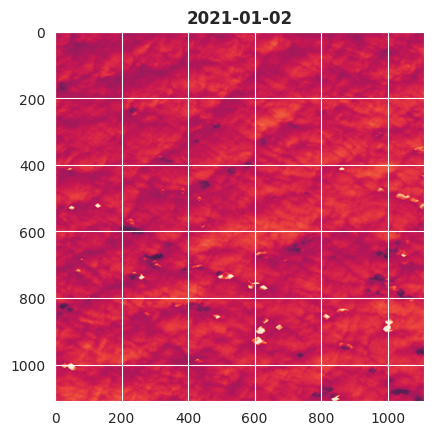

<Axes: title={'center': '2021-01-02'}>

In [ ]:
r_ts = rasterio.open(output_filename_band_timeseries) #rasterio source object
meta_dict = r_ts.meta
print(meta_dict)
date_val = list_dates[0]
print(date_val)
r_ts_a = r_ts.read(1)
print(r_ts_a.shape)
print(r_ts_a)
plot.show(r_ts_a,title=date_val)

We can also plot a specifc band without creating a new array and passing to plot.show using a tuple containing:
- rasterio object r_band_ts
- band number

As shown earlier, this image is not stretched so details may not be visible. We used another color ramp to display the image. You will notice that this time the cartographic coordinates are visible on the plot.

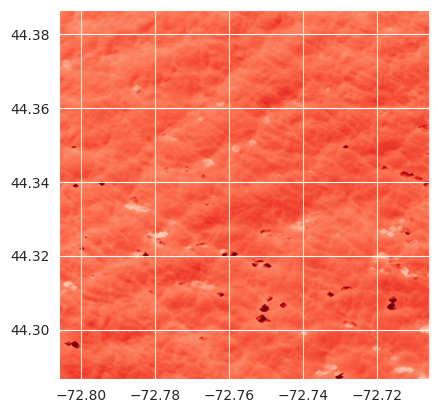

<Axes: >

In [ ]:
plot.show((r_ts,1),cmap='Reds') #can pick a band this way

Let's further improve the plot by adding a color bar and looking at an image that doesn't contain mostly cloud. We plot the last image of the time series.

2023-10-09


<Axes: title={'center': '2023-10-09'}>

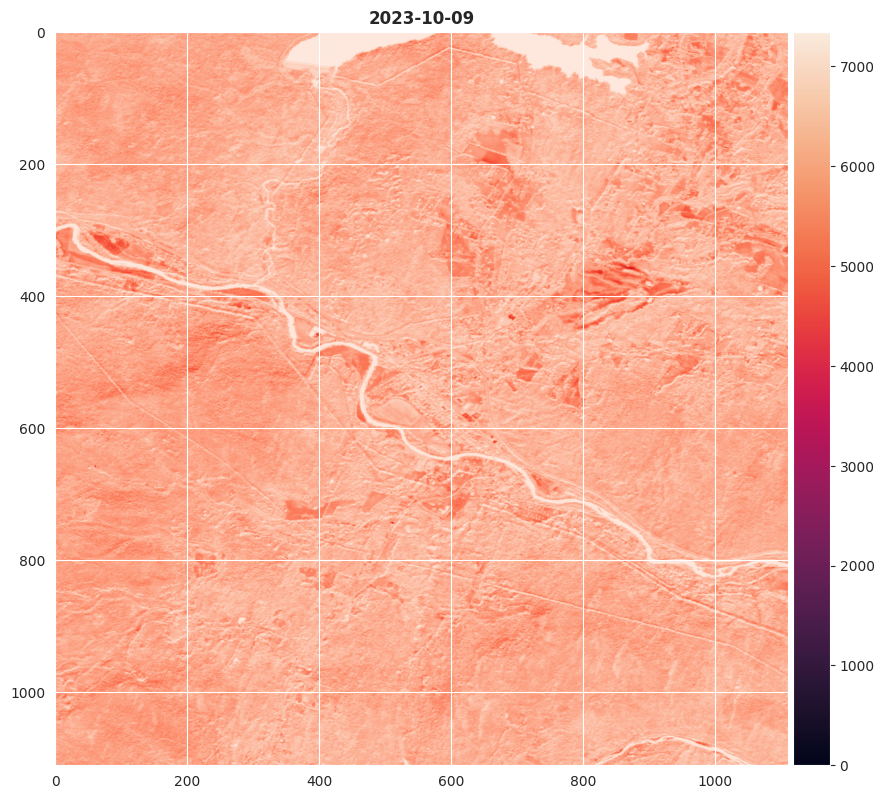

In [ ]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

date_val = list_dates[len(list_dates)-1]
print(date_val)
r_ts_a = r_ts.read(len(list_dates)-1)
i =len(list_dates)-1
fig, ax = plt.subplots(figsize=(10,10))
image_hidden1 = ax.imshow(r_ts.read()[i])
divider1 = make_axes_locatable(ax)
cax1 = divider1.append_axes("right", size="5%", pad=0.05)
fig.colorbar(image_hidden1, ax=ax,cax=cax1,cmap="Reds")
plot.show(r_ts_a,title=date_val,ax=ax,cmap='Reds')

#4.Plot time series images using rioxarray

In the previous section, we used rasterio to visualize time series images. We will now use the package rioxarray. The package relies on xarray and rasterio. The xarray package uses numpy array with additional names for dimensions and attributes instead of indices. This allows working with multi-dimensional arrays data with metadata. In addition, it relies on DASK for parralelization and speed improvement. Xrray data are processed by chunk avoiding reading of large files in memory.


When reading a raster file into a xarray Dataarray object with rasterio, we set:

- masked: is True to set NA values
- chunk: is set to 'auto' so that we use dask.array
- cache: is set to False to read in chunk


Useful links:

- https://docs.digitalearthafrica.org/en/latest/sandbox/notebooks/Frequently_used_code/Working_with_time.html


- https://carpentries-incubator.github.io/geospatial-python/06-raster-intro/


- https://medium.com/@bonnefond.virginie/handling-multi-temporal-satellite-images-with-xarray-30d142d3391


- https://gis.stackexchange.com/questions/446262/create-an-xarray-dataset-form-a-series-of-geotiffs-and-clipping-problem

- https://docs.digitalearthafrica.org/en/latest/sandbox/notebooks/Frequently_used_code/Working_with_time.html

- https://uwgda-jupyterbook.readthedocs.io/en/latest/modules/07_Raster2_DEMs_Warp_Clip_Sample/07_Raster2_DEMs_Warp_Clip_Sample_demo.html

- https://medium.com/@bonnefond.virginie/handling-multi-temporal-satellite-images-with-xarray-30d142d3391

- https://stackoverflow.com/questions/46899337/convert-raster-time-series-of-multiple-geotiff-images-to-netcdf

- https://stackoverflow.com/questions/52133969/convert-tiff-to-netcdf

- https://docs.digitalearthafrica.org/en/latest/sandbox/notebooks/Frequently_used_code/Working_with_time.html


In [ ]:
# Loading TIF file
#import rioxarray as rxr
print(output_filename_band_timeseries)
data_path = output_filename_band_timeseries
ts_ds = rxr.open_rasterio(data_path,
                          masked=True,
                          chunks='auto',
                          cache=False,
                          ) #masked for nodata and cache to avoid loading in memory
ts_ds = ts_ds.astype('uint16')
ts_ds

B08_timeseries.tif


<xarray.DataArray (band: 186, y: 1111, x: 1111)>
dask.array<astype, shape=(186, 1111, 1111), dtype=uint16, chunksize=(1, 1111, 1111), chunktype=numpy.ndarray>
Coordinates:
  * band         (band) int64 1 2 3 4 5 6 7 8 ... 180 181 182 183 184 185 186
  * x            (x) float64 -72.81 -72.81 -72.81 ... -72.71 -72.71 -72.71
  * y            (y) float64 44.39 44.39 44.39 44.39 ... 44.29 44.29 44.29 44.29
    spatial_ref  int64 0
Attributes:
    AREA_OR_POINT:  Area
    scale_factor:   1.0
    add_offset:     0.0

In [ ]:
if ts_ds.chunks is not None:
    print('It is dask.Array')

It is dask.Array


In [ ]:
#ts_ds = ts_ds.rename({'band': 'time'})
nplist_dates = [np.datetime64(x) for x in list_dates]
ts_ds= ts_ds.assign_coords({"band" : nplist_dates})
ts_ds= ts_ds.rename({"band" : "time"})
ts_ds

<xarray.DataArray (time: 186, y: 1111, x: 1111)>
dask.array<astype, shape=(186, 1111, 1111), dtype=uint16, chunksize=(1, 1111, 1111), chunktype=numpy.ndarray>
Coordinates:
  * time         (time) datetime64[ns] 2021-01-02 2021-01-07 ... 2023-10-09
  * x            (x) float64 -72.81 -72.81 -72.81 ... -72.71 -72.71 -72.71
  * y            (y) float64 44.39 44.39 44.39 44.39 ... 44.29 44.29 44.29 44.29
    spatial_ref  int64 0
Attributes:
    AREA_OR_POINT:  Area
    scale_factor:   1.0
    add_offset:     0.0

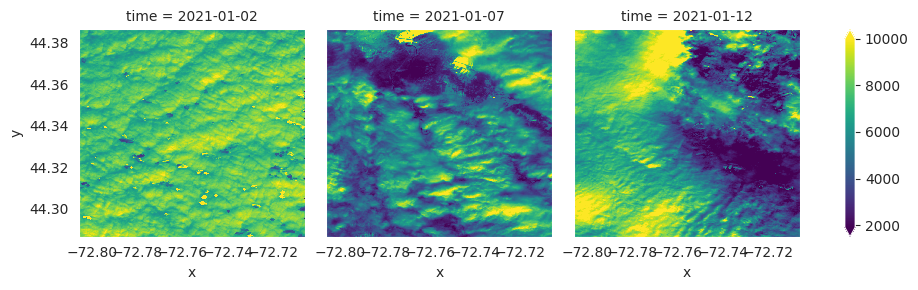

In [ ]:
#https://docs.digitalearthafrica.org/en/latest/sandbox/notebooks/Frequently_used_code/Working_with_time.html
many_times = np.array([
    '2021-01-02',
    '2021-01-07',
    '2021-01-12'
], dtype=np.datetime64)

ts_ds.sel(time=many_times, method='nearest').plot(col='time',robust=True)

#nearest.blue.plot(col='time', vmin=0);

We plot the first three dates of the time series with image enhancement using 2% percentifle for stretching using the option robust. Note all the three first images from the time series contain clouds.

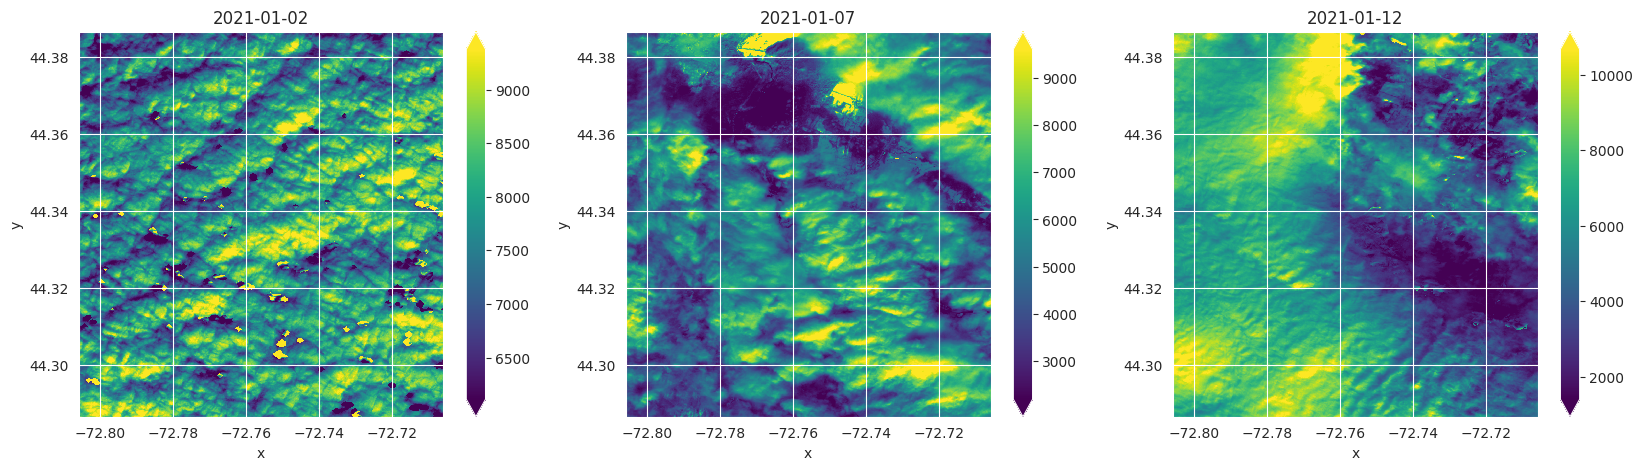

In [ ]:
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(20, 5))
i=0
for ax in axs:
  ts_ds.isel(time=i).plot.imshow(robust=True,ax=ax)#
  #ax.set_title(list_dates[i-1])
  ax.set_title(list_dates[i])
  i=i+1


Let's plot images before and after the event. The first step is for us to find the images before and after closest to the event date. This is shown below

In [ ]:
date_selected_before, date_selected_after = find_target_dates(list_dates=list_dates,
                                                              event_date=event_date)
print(date_selected_before,list_dates.index(date_selected_before))
print(date_selected_after,list_dates.index(date_selected_after))

2023-07-06 168
2023-07-11 169


We identfied images before and after the event in the time series with image enhancement using 2% percentifle for stretching using the option robust. We can clearly see that NIR images show flooding near the river area when we compared the 2023-07-06 and 2023-07-11 images. The impact of the flooding event is not visible on the third image becuase of the clouds.

['2023-07-06', '2023-07-11', '2023-07-16']


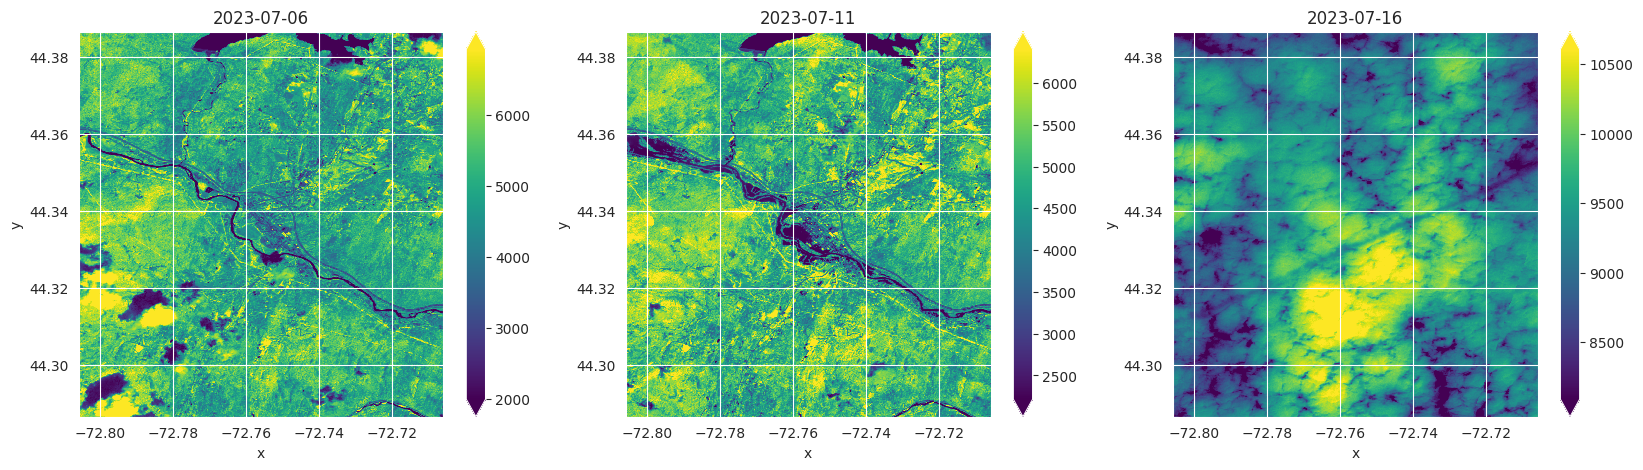

In [ ]:
index_val = list_dates.index(date_selected_before)
print(list_dates[index_val:index_val+3])
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(20, 5))
i=index_val
for ax in axs:
  ts_ds.isel(time=i).plot.imshow(robust=True,ax=ax)
  #ax.set_title(list_dates[i-1])
  ax.set_title(list_dates[i])
  i=i +1


The previous plot is stretched with using the precentile which allows to better see image content. It becomes however difficult to compare values across the theee images in the squence. In order to do so we should standardized the range across all there images. Thiis what we do below using rasterio for comparison.

['2023-07-06', '2023-07-11', '2023-07-16']


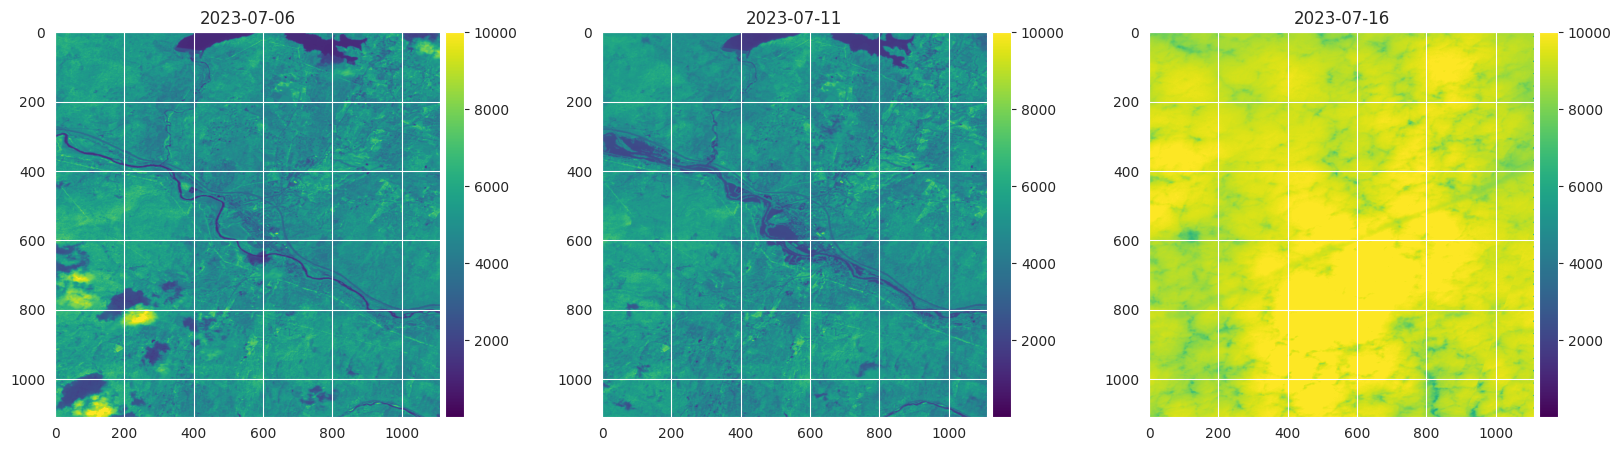

In [ ]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
index_val = list_dates.index(date_selected_before)
ts_dst = rasterio.open(data_path) #masked for nodata and cache to avoid loading in memory

print(list_dates[index_val:index_val+3])
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(20, 5))
i=index_val
for ax in axs:
  i=i +1
  image_hidden1 = ax.imshow(ts_dst.read()[i],clim=(1,10000),cmap='viridis')
  divider1 = make_axes_locatable(ax)
  cax1 = divider1.append_axes("right", size="5%", pad=0.05)
  fig.colorbar(image_hidden1, ax=ax,cax=cax1,cmap='viridis')
  plot.show(ts_dst.read(i),ax=ax,cmap='viridis',clim=(1,10000))
  ax.set_title(list_dates[i-1])

In [ ]:
val_start_date_formatted = event_date.replace('-',"")
data_path = f'./sentinel-2-l2a/{val_start_date_formatted}'
os.environ['DATA_PATH'] = data_path
!ls -ltr $DATA_PATH

ls: cannot access './sentinel-2-l2a/20230710': No such file or directory


#5.Plotting true color composite before and after event: GDAL rasterio

Visualizing images using true color RGB can be very useful. To create a RGB true color composite we need to following steps:

- first need to identify the relevant bands red, blue green value - create a RGB VRT file
- create a RGB tif file if necessary
- strecthed the values in the RGB to improve visualization

To efficiently strech values without reading all the RGB band in memorey,  we use gdal_tranlsate with the scaling option to rescale the band using min max values extracted from the files when creating RGB images.


Useful links:

-https://gis.stackexchange.com/questions/239845/calculate-percentiles-with-gdal-calc

- https://gis.stackexchange.com/questions/257836/raw-sentinel-2-jp2-to-rgb-geotiff

- https://stackoverflow.com/questions/50504205/gdal-translate-scale-and-save-to-jpg-using-python


In [ ]:
list_df_files_raster = []
bands_pattern_val_list =['B04','B03','B02']
for band_pattern_val in bands_pattern_val_list:
  in_dir_files =  os.path.join(out_dir,'sentinel-2-l2a','*')
  file_pattern = f'crop_proj_sentinel*{band_pattern_val}*.tif'
  path_raster = os.path.join(in_dir_files,file_pattern) #raw raster
  files_raster_sat = glob.glob(path_raster,recursive=True)
  df_files_raster_val = pd.DataFrame({'files':files_raster_sat})
  list_df_files_raster.append(df_files_raster_val)

df_files_raster_RGB = pd.concat(list_df_files_raster,axis=1)
df_files_raster_RGB.columns=['B04','B03','B02']

df_files_raster_RGB['date'] = (df_files_raster_RGB['B04'].str.split("_").str[-1]).str.replace(".tif","")
df_files_raster_RGB['date'] = (pd.to_datetime(df_files_raster_RGB['date']))
df_files_raster_RGB = df_files_raster_RGB.sort_values(by='date')
df_files_raster_RGB = df_files_raster_RGB.reset_index(drop=True)
df_files_raster_RGB

<ipython-input-95-6219bf839043>:14: FutureWarning: The default value of regex will change from True to False in a future version.
  df_files_raster_RGB['date'] = (df_files_raster_RGB['B04'].str.split("_").str[-1]).str.replace(".tif","")


B04  \
0    /content/gdrive/MyDrive/Colab Notebooks/Earth_...   
1    /content/gdrive/MyDrive/Colab Notebooks/Earth_...   
2    /content/gdrive/MyDrive/Colab Notebooks/Earth_...   
3    /content/gdrive/MyDrive/Colab Notebooks/Earth_...   
4    /content/gdrive/MyDrive/Colab Notebooks/Earth_...   
..                                                 ...   
181  /content/gdrive/MyDrive/Colab Notebooks/Earth_...   
182  /content/gdrive/MyDrive/Colab Notebooks/Earth_...   
183  /content/gdrive/MyDrive/Colab Notebooks/Earth_...   
184  /content/gdrive/MyDrive/Colab Notebooks/Earth_...   
185  /content/gdrive/MyDrive/Colab Notebooks/Earth_...   

                                                   B03  \
0    /content/gdrive/MyDrive/Colab Notebooks/Earth_...   
1    /content/gdrive/MyDrive/Colab Notebooks/Earth_...   
2    /content/gdrive/MyDrive/Colab Notebooks/Earth_...   
3    /content/gdrive/MyDrive/Colab Notebooks/Earth_...   
4    /content/gdrive/MyDrive/Colab Notebooks/Earth_...   
..                                                 ...   
181  /content/gdrive/MyDrive/Colab Notebooks/Earth_...   
182  /content/gdrive/MyDrive/Colab Notebooks/Earth_...   
183  /content/gdrive/MyDrive/Colab Notebooks/Earth_...   
184  /content/gdrive/MyDrive/Colab Notebooks/Earth_...   
185  /content/gdrive/MyDrive/Colab Notebooks/Earth_...   

                                                   B02       date  
0    /content/gdrive/MyDrive/Colab Notebooks/Earth_... 2021-01-02  
1    /content/gdrive/MyDrive/Colab Notebooks/Earth_... 2021-01-07  
2    /content/gdrive/MyDrive/Colab Notebooks/Earth_... 2021-01-12  
3    /content/gdrive/MyDrive/Colab Notebooks/Earth_... 2021-01-17  
4    /content/gdrive/MyDrive/Colab Notebooks/Earth_... 2021-01-22  
..                                                 ...        ...  
181  /content/gdrive/MyDrive/Colab Notebooks/Earth_... 2023-09-19  
182  /content/gdrive/MyDrive/Colab Notebooks/Earth_... 2023-09-24  
183  /content/gdrive/MyDrive/Colab Notebooks/Earth_... 2023-09-29  
184  /content/gdrive/MyDrive/Colab Notebooks/Earth_... 2023-10-04  
185  /content/gdrive/MyDrive/Colab Notebooks/Earth_... 2023-10-09  

[186 rows x 4 columns]

In [ ]:
raster_file_list_m = df_files_raster_RGB.loc[df_files_raster_RGB['date']==date_selected_after,['B04','B03','B02']].values.flatten().tolist()
raster_file_list_m

['/content/gdrive/MyDrive/Colab Notebooks/Earth_Observation_Remote_Sensing/outputs/output_data_VT_flooding_stac_processing_sentinel2_20231011/sentinel-2-l2a/20230711/crop_proj_sentinel-2-l2a_assets.B04.href_20230711.tif',
 '/content/gdrive/MyDrive/Colab Notebooks/Earth_Observation_Remote_Sensing/outputs/output_data_VT_flooding_stac_processing_sentinel2_20231011/sentinel-2-l2a/20230711/crop_proj_sentinel-2-l2a_assets.B03.href_20230711.tif',
 '/content/gdrive/MyDrive/Colab Notebooks/Earth_Observation_Remote_Sensing/outputs/output_data_VT_flooding_stac_processing_sentinel2_20231011/sentinel-2-l2a/20230711/crop_proj_sentinel-2-l2a_assets.B02.href_20230711.tif']

In [ ]:
ds = gdal.BuildVRT( f'RGB_after.vrt',
                   raster_file_list_m,
                    separate=True, #keep files in separate bands, useful for files covering the same area
                    VRTNodata=0,
                    srcNodata=0)
#print(ds.RasterCount)
ds=None

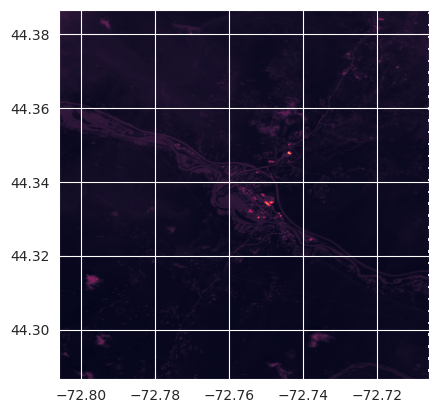

<Axes: >

In [ ]:
dst = rasterio.open('RGB_after.vrt')
plot.show(dst)

In [ ]:
ds = gdal.Open('RGB_after.vrt')
stats=ds.GetRasterBand(1).GetStatistics(0,1)
print(stats)
list_df_stats_RGB = []
for band_val in (1,2,3):
  df_stats_val = update_raster_band_stats('RGB_after.vrt',band_val=band_val)
  list_df_stats_RGB.append(df_stats_val)

df_stats_RGB = pd.concat(list_df_stats_RGB)
df_stats_RGB = df_stats_RGB.reset_index(drop=True)

df_stats_RGB

[1121.0, 8888.0, 1481.908423213413, 234.6026117924543]


min     max         mean         std
0  1121.0  8888.0  1481.908423  234.602612
1  1234.0  9648.0  1745.712899  210.459023
2  1139.0  7744.0  1514.902690  220.221366

In [ ]:
list_args = ['gdal_translate',
              f'-scale_1 {str(df_stats_RGB.loc[0,["min"]].values[0])} {str(df_stats_RGB.loc[0,["max"]].values[0])} {0} {255}',
              f'-scale_2 {str(df_stats_RGB.loc[1,["min"]].values[0])} {str(df_stats_RGB.loc[1,["max"]].values[0])} {0} {255}',
              f'-scale_3 {str(df_stats_RGB.loc[2,["min"]].values[0])} {str(df_stats_RGB.loc[2,["max"]].values[0])} {0} {255}',
              f'-ot Byte',
             'RGB_after.vrt',
             'RGB_after_stretched.tif']

cmd_str = ' '.join([str(elem) for elem in list_args])
import subprocess
env = os.environ.copy() #this is necessary in google colab
output_sub = subprocess.check_output(cmd_str, shell=True, env=env,text=True)
print(cmd_str)


gdal_translate -scale_1 1121.0 8888.0 0 255 -scale_2 1234.0 9648.0 0 255 -scale_3 1139.0 7744.0 0 255 -ot Byte RGB_after.vrt RGB_after_stretched.tif


Let's now use the use the function to plot before and after events.


In [ ]:
out_filename,cmd_str=create_RGB(in_filename='RGB_after.vrt',
           out_filename='RGB_after_stretched.tif',
           scale_list=None,
           out_dtype='Byte')
print(cmd_str)

[1121.0, 8888.0, 1481.9084232134, 234.60261179245]
gdal_translate -scale_1 1121.0 8888.0 0 255 -scale_2 1234.0 9648.0 0 255 -scale_3 1139.0 7744.0 0 255 -ot Byte RGB_after.vrt RGB_after_stretched.tif


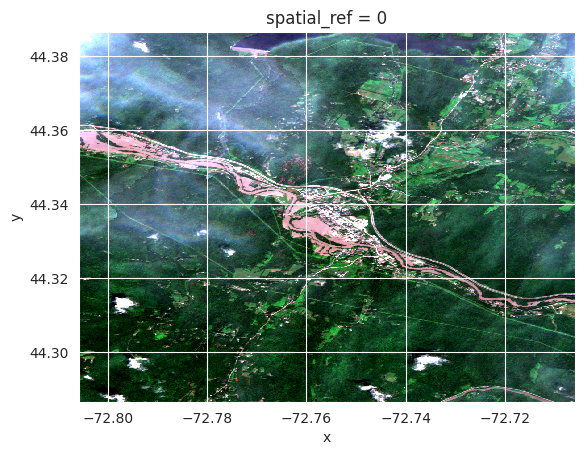

In [ ]:
rds = rxr.open_rasterio('RGB_after_stretched.tif', masked=True,cache=False)
rds
rds.astype("uint8").plot.imshow(rgb="band",robust=True)

[1113.0, 11592.0, 1512.95736081993, 786.9404051483809]
gdal_translate -scale_1 1121.0 8888.0 0 255 -scale_2 1234.0 9648.0 0 255 -scale_3 1139.0 7744.0 0 255 -ot Byte RGB_before.vrt RGB_before_stretched.tif


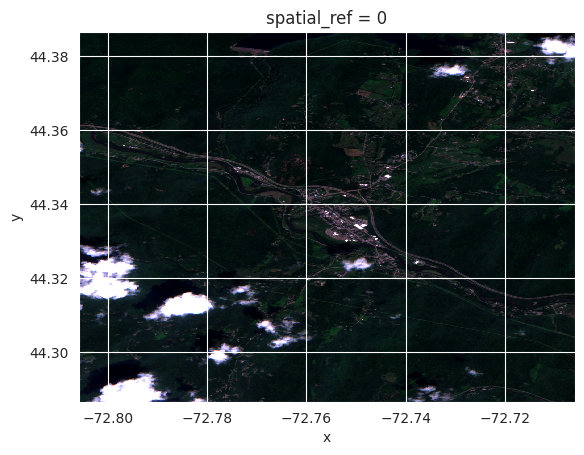

In [ ]:
raster_file_list_m = df_files_raster_RGB.loc[df_files_raster['date']==date_selected_before,['B04','B03','B02']].values.flatten().tolist()
ds = gdal.BuildVRT( f'RGB_before.vrt',
                   raster_file_list_m,
                    separate=True, #keep files in separate bands, useful for files covering the same area
                    VRTNodata=0,
                    srcNodata=0)
#print(ds.RasterCount)
ds=None

out_filename,cmd_str=create_RGB(in_filename='RGB_before.vrt',
           out_filename='RGB_before_stretched.tif',
           scale_list=None,
           out_dtype='Byte')
print(cmd_str)
rds = rxr.open_rasterio('RGB_before_stretched.tif', masked=True,cache=False)
rds
rds.astype("uint8").plot.imshow(rgb="band",robust=True)

We examined  stretched true color composite for the date before and after the event and find that:

- the flooding event is clearly visible
- the strectching works much better for the date after

We could improve the true color composite using other stretching (2% percentile is often used) or take a look at a flase color composite.

#6.Plot color composites using xarray

#7.Update decription band names, statistics and plot average time series profiles

We generated a geotif but nothing indicates that every band in the multiband files refers to an observation at a specific time step (date). We use gdalinfo to show that the band description does not include the dates. We can update every band with a date value. So we need to edit the band name in the description of the tif files and check that the band order when creating the tif file is descending (from the first date to the last date).

Useful links:

- https://gis.stackexchange.com/questions/290796/how-to-edit-the-metadata-for-individual-bands-of-a-multiband-raster-preferably

In [ ]:
raster_in_filename=output_filename_band_timeseries
list_args =['gdalinfo',
raster_in_filename]
cmd_str = ' '.join([str(elem) for elem in list_args])
print(cmd_str)
import subprocess
env = os.environ.copy() #this is necessary in google colab
output_sub = subprocess.check_output(cmd_str, shell=True, env=env)
output_sub

gdalinfo B08_timeseries.tif


b'Driver: GTiff/GeoTIFF\nFiles: B08_timeseries.tif\nSize is 1111, 1111\nCoordinate System is:\nGEOGCRS["WGS 84",\n    DATUM["World Geodetic System 1984",\n        ELLIPSOID["WGS 84",6378137,298.257223563,\n            LENGTHUNIT["metre",1]]],\n    PRIMEM["Greenwich",0,\n        ANGLEUNIT["degree",0.0174532925199433]],\n    CS[ellipsoidal,2],\n        AXIS["geodetic latitude (Lat)",north,\n            ORDER[1],\n            ANGLEUNIT["degree",0.0174532925199433]],\n        AXIS["geodetic longitude (Lon)",east,\n            ORDER[2],\n            ANGLEUNIT["degree",0.0174532925199433]],\n    ID["EPSG",4326]]\nData axis to CRS axis mapping: 2,1\nOrigin = (-72.805889721278177,44.386538729787461)\nPixel Size = (0.000090000000000,-0.000090000000000)\nMetadata:\n  AREA_OR_POINT=Area\nImage Structure Metadata:\n  COMPRESSION=DEFLATE\n  INTERLEAVE=PIXEL\nCorner Coordinates:\nUpper Left  ( -72.8058897,  44.3865387) ( 72d48\'21.20"W, 44d23\'11.54"N)\nLower Left  ( -72.8058897,  44.2865487) ( 72d4

186


files         mean
date                                                                      
2021-01-02  /content/gdrive/MyDrive/Colab Notebooks/Earth_...  7779.637364
2021-01-07  /content/gdrive/MyDrive/Colab Notebooks/Earth_...  5352.704587
2021-01-12  /content/gdrive/MyDrive/Colab Notebooks/Earth_...  5910.621701
2021-01-17  /content/gdrive/MyDrive/Colab Notebooks/Earth_...  7151.100357
2021-01-22  /content/gdrive/MyDrive/Colab Notebooks/Earth_...  8939.349546
...                                                       ...          ...
2023-09-19  /content/gdrive/MyDrive/Colab Notebooks/Earth_...  6502.861972
2023-09-24  /content/gdrive/MyDrive/Colab Notebooks/Earth_...  7082.917338
2023-09-29  /content/gdrive/MyDrive/Colab Notebooks/Earth_...  8329.751650
2023-10-04  /content/gdrive/MyDrive/Colab Notebooks/Earth_...  3564.626898
2023-10-09  /content/gdrive/MyDrive/Colab Notebooks/Earth_...  5341.052896

[186 rows x 2 columns]

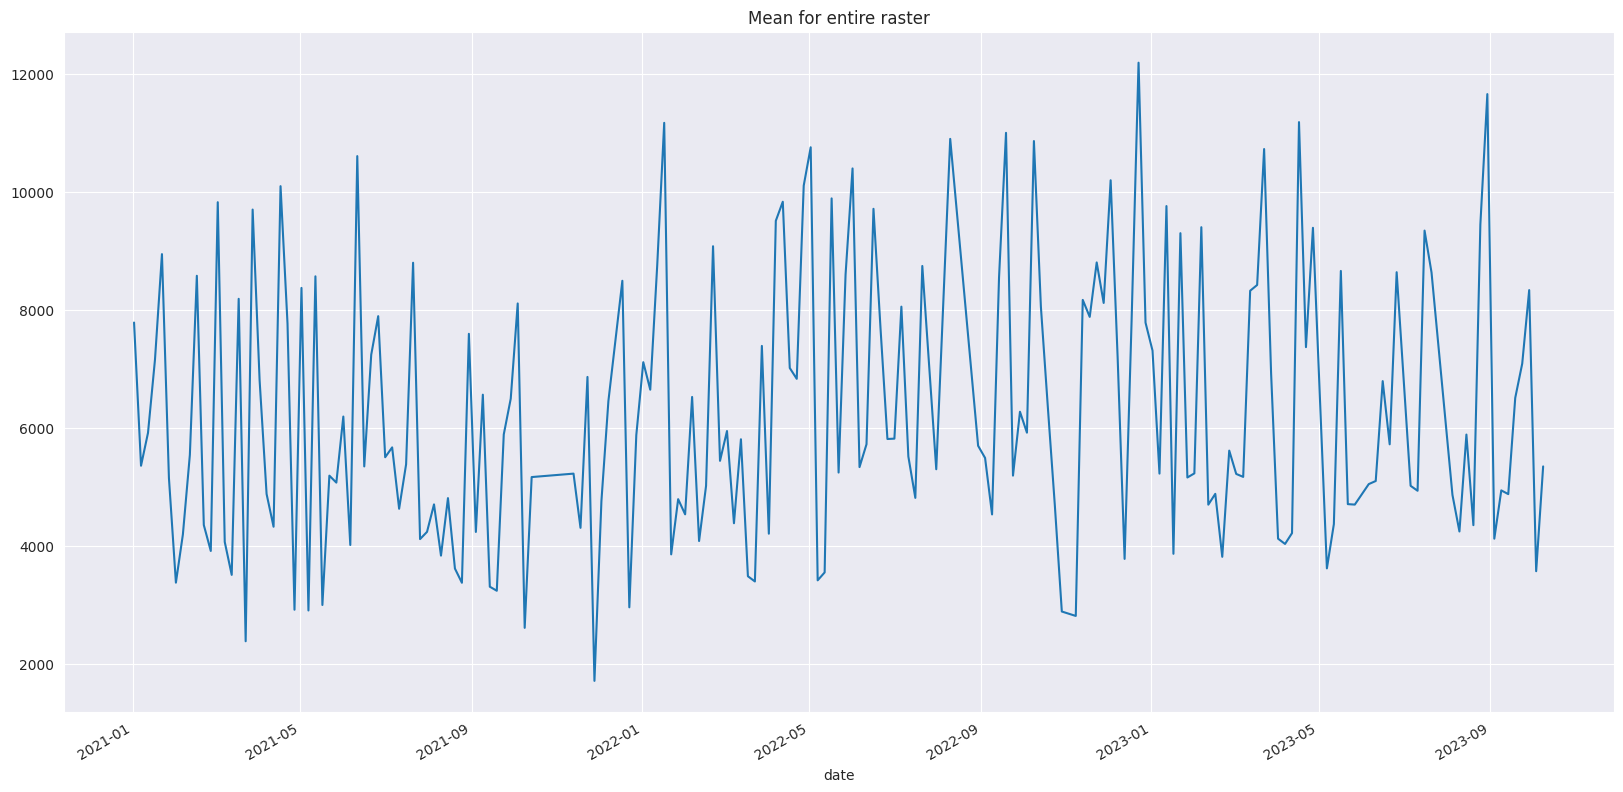

In [ ]:
#This took 6min and 28sec, too long, need to parallelize
list_mean_val = []
for i in np.arange(1,len(list_dates)+1):
  val=(r_ts.statistics(i))
  list_mean_val.append(val.mean)

print(len(list_mean_val))
df_files_raster['mean'] = list_mean_val
df_files_raster.set_index('date', inplace=True)
df_files_raster['mean'].plot(figsize=(20, 10),
                             title='Mean for entire raster')
df_files_raster

In [ ]:
#adding description in the tiff file creates some issues when plotting with rioxarray, neeed to fix this issue
if add_description is True:

  print(r_ts.descriptions[:5]) #no description before
  ds_time_series = gdal.Open(output_filename_band_timeseries,
                            gdal.GA_Update)
  list_desc = list_dates
  i=0
  for desc_val in list_desc:
    i=i+1
    rb = ds_time_series.GetRasterBand(i)
    rb.SetDescription(desc_val)
  del ds_time_series
  r_band_ts = rasterio.open(output_filename_band_timeseries) #rasterio source object
  r_band_ts.descriptions[:5]


<Axes: title={'center': 'Mean for entire raster'}, xlabel='date'>

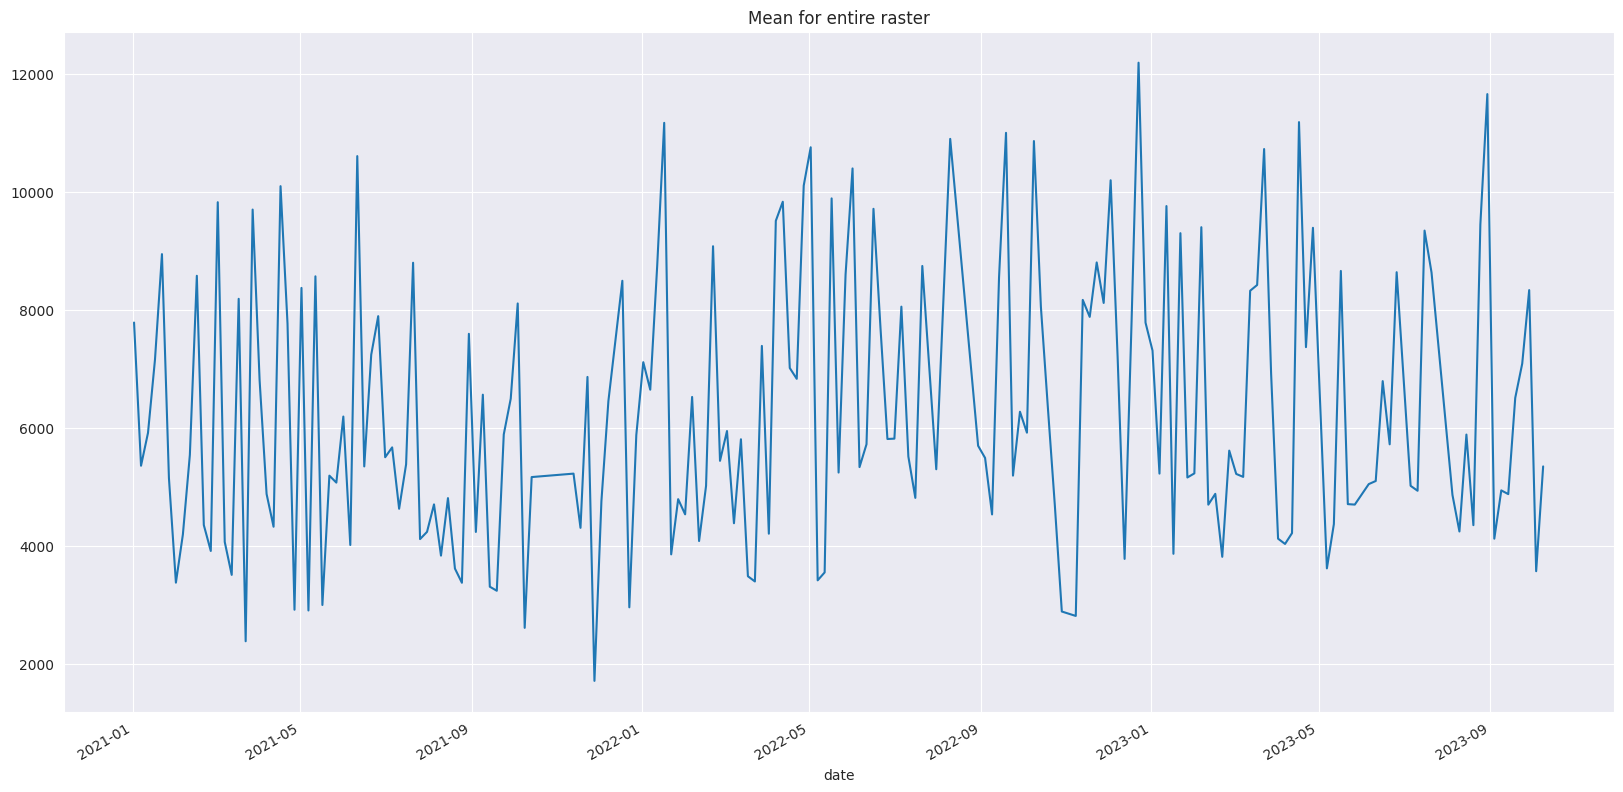

In [ ]:
df_files_raster['mean'] = list_mean_val
df_files_raster['mean'].plot(figsize=(20, 10),
                             title='Mean for entire raster')

From the time series plot we can see that we need to screen the images for zero values and that we have a few very hight values over 10,000. The valid range should be between 1 and 10,000 for the surface reflectance. This will be done at the same time as masking low quality pixels.

#8.Conclusions

In this blog/exercise, we explored the impact of a major flooding event in Vermont using Sentinel 2, satellite imagery data. We showed how to download and process Sentinel 2 data for multiple dates (almost three years) using COGS and STAC framework.

The overall gaol was also to show how to leverage Sentinel 2 data once procesed. We used Sentinel2 data to assess the impact of flooding in multiple ways:

1. Visual impact with raw bands:

We compared the date before and after visually using raw bands from Sentinel 2.

- visual impact of flooding using true color composite (RGB)
- visual impact using NIR (band 08).

2. Visual impact with NDVI and NDWI indices

Raw spectral bands are useful but spectral indices made up of a combination of bands can help in highlitghting specific features on the ground surface.
We created the Normalized Difference Vegetation Index and the Normalized Difference Water Index to detect the impact of flooding on vegetation and water areas. We exepect NDVI values close to zero or negative for flooded areas and for NDWI values we expect hight values (above 0.5) for flooded areas.

3. Using time series profiles

We examined individual and average time sereis profile at dfferent location int the AOI and detected drop or rise at the time of the event for NDVI and NDWI respectively.


**Improvements**

We hope that this blog/exercise provided a complete example of workflow for the use of Sentinel 2 data with STAC and COGS. As expected, there are several improvements that could be made:

- thresholds results using NDVI or NDWI to map flooding event.
- use an algorithm/model map the area flooded.

#9.References


Obregón, M.A., Rodrigues, G., Costa, M.J., et al. (2019). Validation of ESA Sentinel-2 L2A aerosol optical thickness and columnar water vapour during 2017-2018. Remote Sensing, 11(14), 1649. https://doi.org/10.3390/rs11141649

Schläpfer, D., Borel, C.C., Keller, J., et al. (1998). Atmospheric precorrected differential absorption technique to retrieve columnar water vapor. Remote Sensing of Environment, 65(3), 353-366. https://doi.org/10.1016/S0034-4257(98)00044-3.

Gascon F., Bouzinac C., Thépaut O., et al. (2017). Copernicus Sentinel-2A calibration and products validation status. Remote Sensing, 9(6), 584. https://doi.org/10.3390/rs9060584


In [ ]:
############################# END OF SCRIPT ###################################